# Business Analytics
In this Project we will optimize marketing expenses for Yandex.Afisha services.

We have:
- Server logs with data on Yandex.Afisha visits from June 2017 through May 2018
- Dump file with all orders for the period
- Marketing expenses statistics

We are going to study:
- How people use the product
- When they start to buy
- How much money each customer brings
- When they pay off  

<br>            
   
## Description of the data:  

The `visits` table (server logs with data on website visits):
- Uid — user's unique identifier
- Device — user's device
- Start Ts — session start date and time
- End Ts — session end date and time
- Source Id — identifier of the ad source the user came from
*All dates in this table are in YYYY-MM-DD format.*

The `orders` table (data on orders):
- Uid — unique identifier of the user making an order
- Buy Ts — order date and time
- Revenue — Yandex.Afisha's revenue from the order

The `costs` table (data on marketing expenses):
- source_id — ad source identifier
- dt — date
- costs — expenses on this ad source on this day

<br>

## Project Steps:  

[Step 1. Download the data and prepare it for analysis](#Step-1.-Download-the-data-and-prepare-it-for-analysis)  
[Step 2. Make reports and calculate metrics:](#Step-2.-Make-reports-and-calculate-metrics:)

###### 1. Product:  

- [How many people use it every day, week, and month?](#How-many-people-use-it-every-day,-week,-and-month?)
- [How many sessions are there per day? (One user might have more than one session.)](#How-many-sessions-are-there-per-day?)
- [What is the length of each session?](#What-is-the-length-of-each-session?)
- [How often do users come back?](#How-often-do-users-come-back?)

###### 2. Sales:

- [When do people start buying?](#When-do-people-start-buying?)
- [How many orders do they make during a given period of time?](#How-many-orders-do-they-make-during-a-given-period-of-time?)
- [What is the average purchase size?](#What-is-the-average-purchase-size?)
- [How much money do they bring? (LTV)](#How-much-money-do-they-bring?-(LTV))

###### 3. Marketing:  

- [How much money was spent? Overall/per source/overtime](#How-much-money-was-spent?-Overall/per-source/overtime)
- [How much did customer acquisition from each of the sources cost?](#How-much-did-customer-acquisition-from-each-of-the-sources-cost?)
- [How worthwhile where the investments? (ROI)](#How-worthwhile-where-the-investments?-(ROI))

[Step 3. Write a conclusion: advise marketing experts how much money to invest and where](#Step-3.-Write-a-conclusion:-advise-marketing-experts-how-much-money-to-invest-and-where.)


## Step 1. Download the data and prepare it for analysis 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math as mt
from scipy import stats as st
import datetime
import time

In [2]:
costs = pd.read_csv('/datasets/costs_us.csv', parse_dates=['cost_ts'], dayfirst=True ,
                    names=['source_id', 'cost_ts', 'costs'], header=0)
orders = pd.read_csv('/datasets/orders_log_us.csv', parse_dates=['order_ts'], dayfirst=True ,
                     names=['order_ts', 'revenue', 'user_id'], header=0)
visits = pd.read_csv('/datasets/visits_log_us.csv', dtype={'device': 'category'},
                    parse_dates=['visit_end_ts', 'visit_start_ts'], dayfirst=True ,
                    names=['device', 'visit_end_ts', 'source_id', 'visit_start_ts', 'user_id'], header=0)

the data was read from the CSV files and stored in dataframes and in the process all the dates columns was parsed and changed to datetime type and the object columns were changed to the approperiate type like `category` and the column names was adjusted.

In [3]:
costs.head()

,source_id,cost_ts,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [4]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
cost_ts      2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [5]:
costs.duplicated().sum()

0

In [6]:
orders.head()

,order_ts,revenue,user_id
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
order_ts    50415 non-null datetime64[ns]
revenue     50415 non-null float64
user_id     50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [8]:
orders.duplicated().sum()

0

In [9]:
visits.head()

,device,visit_end_ts,source_id,visit_start_ts,user_id
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [10]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device            359400 non-null category
visit_end_ts      359400 non-null datetime64[ns]
source_id         359400 non-null int64
visit_start_ts    359400 non-null datetime64[ns]
user_id           359400 non-null uint64
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


In [11]:
visits.duplicated().sum()

0

as it we can notice from the info there are no NA values to be filled and there are no duplicates in our data so the data is clean and we can start working on the analysis.

## Step 2. Make reports and calculate metrics:  
<br>

### 1. Product:  
<br>

####  How many people use it every day, week, and month?  

in this part we have to calculate the DAU, WAU and MAU therefore we will start with adding a new column `visit_date` to our `visits` dataset 

In [12]:
visits['visit_date'] = visits['visit_start_ts'].dt.date
visits.head()

,device,visit_end_ts,source_id,visit_start_ts,user_id,visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27


In [13]:
# creating new sets for required Metrics:

dau = visits.groupby('visit_date').agg({'user_id': 'nunique'}).reset_index()
dau.columns = ['visit_date', 'n_daily_users']
wau = visits.groupby(visits['visit_start_ts'].apply(
    lambda x: x.strftime('%y-%W')))['user_id'].nunique().reset_index()
wau.columns = ['visit_week','n_weekly_users']
mau = visits.groupby(visits['visit_start_ts'].apply(
    lambda x: x.strftime('%Y-%m')))['user_id'].nunique().reset_index()
mau.columns = ['visit_month','n_monthly_users']

lets take alook at the plots for the the sets we created:

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


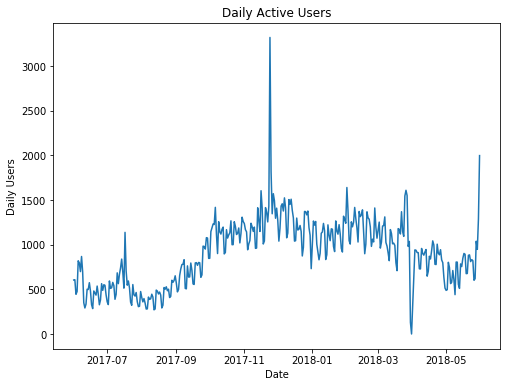

In [14]:
plt.figure(figsize = (8,6));
sns.lineplot(x='visit_date', y='n_daily_users', data= dau).set_title('Daily Active Users')
plt.xlabel('Date');
plt.ylabel('Daily Users');

- from the plot above we can notice that the number of users varies throughout the year and rises in the winter. 
- there is a huge spike in the users in one specific day and huge drop on another. lets take a look at these dates

In [15]:
dau.head()

,visit_date,n_daily_users
0,2017-06-01,605
1,2017-06-02,608
2,2017-06-03,445
3,2017-06-04,476
4,2017-06-05,820


In [16]:
dau[dau['n_daily_users'] == dau['n_daily_users'].max()]

,visit_date,n_daily_users
176,2017-11-24,3319


In [17]:
dau[dau['n_daily_users'] == dau['n_daily_users'].min()]

,visit_date,n_daily_users
303,2018-03-31,1


- the huge spike was around the end of november specifically `24.11.` which was probably `black Friday` so the spike can actualy be explained that there was a big sale.
- on the other hand the drop was on `31.03` when there was nothing special so we can'T explained it now but we will take another look at it in later stages if possible 

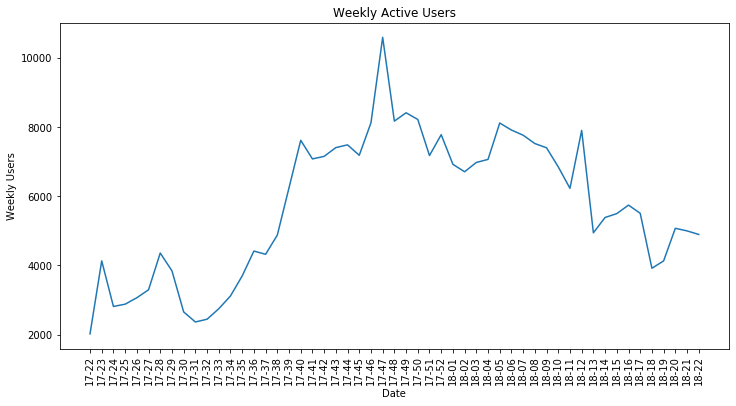

In [18]:
plt.figure(figsize = (12,6));
sns.lineplot(x='visit_week', y='n_weekly_users', data= wau).set_title('Weekly Active Users');
plt.xlabel('Date');
plt.xticks(rotation = 90)
plt.ylabel('Weekly Users');

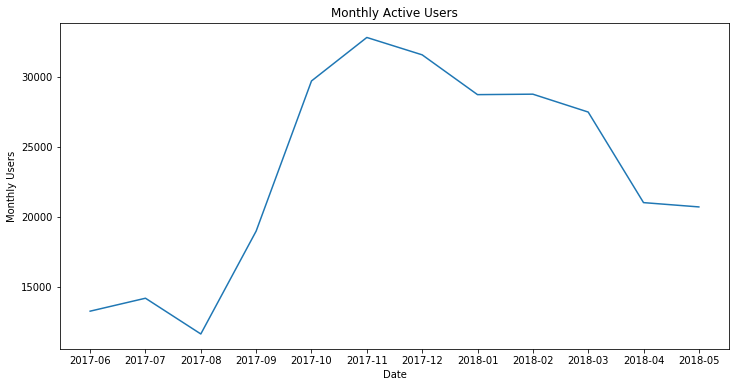

In [19]:
plt.figure(figsize = (12,6));
sns.lineplot(x='visit_month', y='n_monthly_users', data= mau).set_title('Monthly Active Users');
plt.xlabel('Date');
plt.ylabel('Monthly Users');

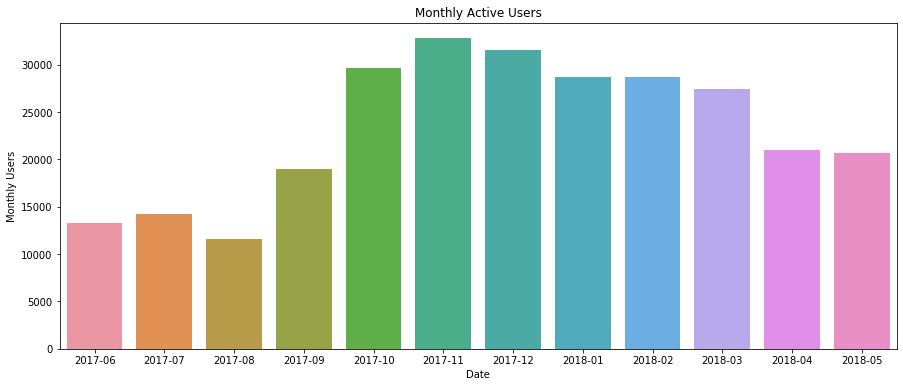

In [20]:
plt.figure(figsize=(15,6))
sns.barplot(y= 'n_monthly_users', x='visit_month' ,data = mau).set_title('Monthly Active Users');
plt.xlabel('Date');
plt.ylabel('Monthly Users');

- from the plots above we notice the same observations that the number of visitors/users rises during the winter months and it reaches the peak in November ('black Friday') 
- the drop wasn't as obvious as it occured in only one day and wasn't noticed in the weekly or monthly number of users which can point out that it can be due to an error in the services ( bug in the system, server is down ,....etc )

In [21]:
print('daily active users:', "{:.2f}".format(dau['n_daily_users'].mean()))
print('weekly active users:', "{:.2f}".format(wau['n_weekly_users'].mean()))
print('monthly active users:', "{:.2f}".format(mau['n_monthly_users'].mean()))

daily active users: 907.99
weekly active users: 5716.25
monthly active users: 23228.42


In [22]:
sticky_wau = (dau['n_daily_users'].mean() / wau['n_weekly_users'].mean() ) *100
sticky_mau = (dau['n_daily_users'].mean()  / mau['n_monthly_users'].mean() ) *100

In [23]:
print('weekly sticky factor:', "{:.2f}".format(sticky_wau))
print('monthly sticky factor:', "{:.2f}".format(sticky_mau))

weekly sticky factor: 15.88
monthly sticky factor: 3.91


with a general calculation we can find out the following average numbers of users:
- daily active users: 907.99
- weekly active users: 5716.25
- monthly active users: 23228.42

with a the following sticky factors: 
- weekly sticky factor: 15.88
- monthly sticky factor: 3.91

#### How many sessions are there per day?

to study the daily sessions it will be more benefetial to compare it with the number of the daily users so we will create the the dataset `daily_sessions` and plot it to make the comparision easier

In [24]:
daily_sessions = visits.groupby('visit_date').agg({'user_id': ['nunique', 'count']}).reset_index()
daily_sessions.columns = ['visit_date','n_users', 'n_sessions']
daily_sessions.head()

,visit_date,n_users,n_sessions
0,2017-06-01,605,664
1,2017-06-02,608,658
2,2017-06-03,445,477
3,2017-06-04,476,510
4,2017-06-05,820,893


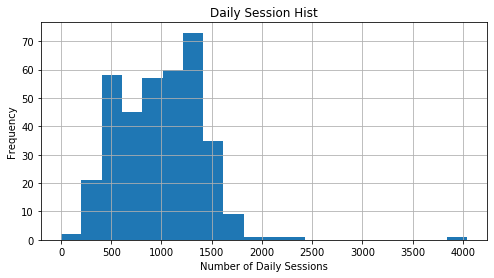

In [25]:
plt.figure(figsize = (8,4));
daily_sessions['n_sessions'].hist(bins= 20).set_title('Daily Session Hist');
plt.xlabel('Number of Daily Sessions');
plt.ylabel('Frequency');

In [26]:
print('Average Sessions per day:',"{:.2f}".format(daily_sessions['n_sessions'].mean()))

Average Sessions per day: 987.36


- from the histogram we can see that the number of sessions mostly ranges from 500 to 1500 session per day
- We see that on average ther is around 987 Session per day 

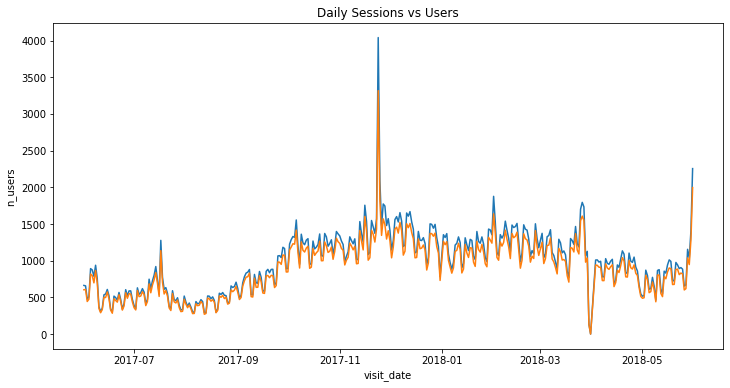

In [27]:
plt.figure(figsize = (12,6));
plt.title('Daily Sessions vs Users')
plt.ylabel('Daily Count')
sns.lineplot(y='n_sessions', x ='visit_date', data= daily_sessions);
sns.lineplot(y='n_users', x ='visit_date', data= daily_sessions);

when we compare it the number of daily sessions to the number of daily users we can see that the plots are almost identical which indicates that every user has around only 1 session per day which makes sense as the service is for buying concerts tickets so usually the users logs in buy what they want and then leave without the need for a second session in the same day. 

In [28]:
visits.head()

,device,visit_end_ts,source_id,visit_start_ts,user_id,visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27


In [29]:
daily_sessions_user = visits.groupby(['visit_date','user_id']).agg(
    {'visit_start_ts': 'count'}).reset_index()
daily_sessions_user = daily_sessions_user.rename(columns = {'visit_start_ts': 'n_sessions'})
daily_sessions_user

,visit_date,user_id,n_sessions
0,2017-06-01,32197920403662046,1
1,2017-06-01,184148767273119549,2
2,2017-06-01,254239507810036143,1
3,2017-06-01,258099436367309303,1
4,2017-06-01,300776506671194537,1
...,...,...,...
330504,2018-05-31,18413292963150477112,1
330505,2018-05-31,18428173890345346536,1
330506,2018-05-31,18428797902626915731,1
330507,2018-05-31,18438521692156628706,1


In [30]:
average_serssions_user = daily_sessions_user.groupby('user_id')['n_sessions'].mean().reset_index()
average_serssions_user.head()

,user_id,n_sessions
0,11863502262781,1.0
1,49537067089222,1.0
2,297729379853735,1.0
3,313578113262317,1.0
4,325320750514679,1.0


In [31]:
print('Average Sessions per day per each user:',"{:.2f}".format(average_serssions_user['n_sessions'].mean()))

Average Sessions per day per each user: 1.05


we can see that on average we each user has around 1 session per day and 1.05 to be exact

In [32]:
# calculation the average number of daily sessions per user
daily_sessions_device = visits.groupby(['visit_date','device']).agg(
    {'user_id': ['count', 'nunique']}).reset_index()
daily_sessions_device.columns = ['visit_date', 'device','n_sessions', 'n_users']
daily_sessions_device['average_sessions_per_user'] = (
    daily_sessions_device['n_sessions'] / daily_sessions_device['n_users'])
daily_sessions_device.head(10)

,visit_date,device,n_sessions,n_users,average_sessions_per_user
0,2017-06-01,desktop,501,455,1.101099
1,2017-06-01,touch,163,153,1.065359
2,2017-06-02,desktop,498,458,1.087336
3,2017-06-02,touch,160,152,1.052632
4,2017-06-03,desktop,329,307,1.071661
5,2017-06-03,touch,148,139,1.064748
6,2017-06-04,desktop,349,326,1.070552
7,2017-06-04,touch,161,153,1.052288
8,2017-06-05,desktop,693,631,1.098257
9,2017-06-05,touch,200,195,1.025641


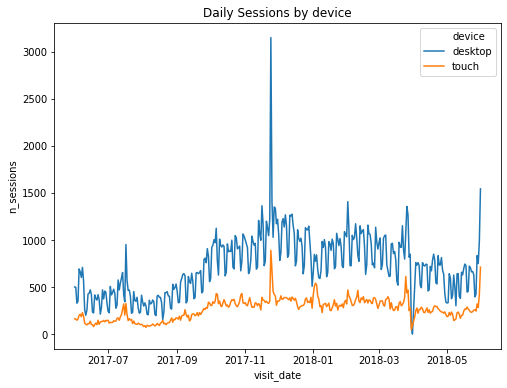

In [33]:
plt.figure(figsize = (8,6));
plt.title('Daily Sessions by device');
plt.ylabel('Number of Sessions');
plt.xlabel('Date');
sns.lineplot(y='n_sessions', x ='visit_date', data= daily_sessions_device, hue='device');

- When comparing the number daily sessions based on the device used we notice that the desktop version is more popular than the touch version which can indicate that the touch version is not user friendly and can use some improvement. but in general the usage trends for both versions are basicaly the same with the same ups and downs in. 
- we can notice that on the `31.03.` both versions had the same drop in sessions which means that the fault wasn't in one version but most probably it was a general server error.

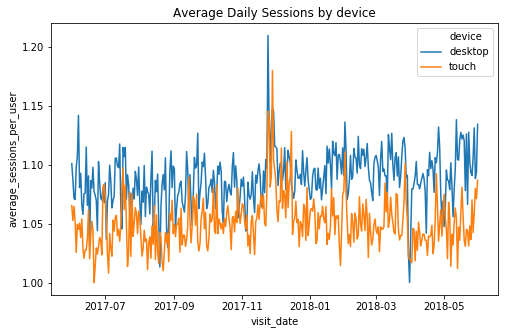

In [34]:
plt.figure(figsize = (8,5));
plt.title('Average Daily Sessions by device');
plt.ylabel('Average Number of Sessions');
plt.xlabel('Date');
sns.lineplot(y='average_sessions_per_user', x ='visit_date', data= daily_sessions_device, hue='device');

- the graph above shows that in general the average daily sessions per user in both versions is around 1 - 1.2 session per day which is infact not a bad thing from a developer point of view as it indicates that the services are easy and clear enough that the users can finish their objects in 1 session. 
- from a marketing point of view we can say that the service can be more inviting so the users will have the urge to check it more frequently which may lead to more sales and purchases. 

#### What is the length of each session?

<div class="alert alert-info"> <b>Student's comment:</b> From here starts the calculation for the note below</div>

In [35]:
visits['session_duration_sec'] = (visits['visit_end_ts'] - visits['visit_start_ts']).dt.seconds
visits['session_duration_min'] = visits['session_duration_sec'] / 60
visits.head()

,device,visit_end_ts,source_id,visit_start_ts,user_id,visit_date,session_duration_sec,session_duration_min
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,1080,18.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,1680,28.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,0,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,1440,24.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,0,0.0


In [36]:
visits['session_duration_sec'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

In [37]:
visits[visits['session_duration_sec'] > 0]['session_duration_sec'].describe()

count    323606.000000
mean        714.684623
std        1047.052806
min          19.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

In [38]:
visits[(visits['session_duration_sec'] >= 19) & (visits['session_duration_sec'] < 60)]['session_duration_sec'].describe()

count    868.0
mean      19.0
std        0.0
min       19.0
25%       19.0
50%       19.0
75%       19.0
max       19.0
Name: session_duration_sec, dtype: float64

In [39]:
# percentage of the sessions with 0 seconds length 
(visits[visits['session_duration_sec'] == 0]['user_id'].count() / visits['session_duration_sec'].count()) * 100

9.959376739009459

In [40]:
# percentage of the sessions with length more than 1 hour
(visits[visits['session_duration_sec'] >= 2700]['user_id'].count() / visits['session_duration_sec'].count()) * 100

3.641346688925988

- we see that the minimum length is 0 seconds which can mean that the either the session was less than 1 Minute or that it was immediatly closed. 
- other than the 0 length sessions we have sessions with exactly 19 seconds and these are the only sessions with less 60 seconds which is odd as most of our ts don't count for seconds 
- the maximum length is 84480 seconds which is almost a whole day so these can be either a mistake in the logs system or that the session was opened and forgotten without being closed
- in both cases these should be considered outliers and should be dropped from our length calculations.
- to get rid of the outliers we decided to drop all the sessions that are longer than 45 mins (2700 seconds) which make around 3.6% of our data and all the sessions with 0 seconds length which make 10% of our data so all topgether we will drop 13.6% and keep 86.4%

In [41]:
length_sec = visits[['visit_start_ts','session_duration_sec', 'user_id' , 'source_id', 'device', 'visit_date']].copy()
length_sec.head()

,visit_start_ts,session_duration_sec,user_id,source_id,device,visit_date
0,2017-12-20 17:20:00,1080,16879256277535980062,4,touch,2017-12-20
1,2018-02-19 16:53:00,1680,104060357244891740,2,desktop,2018-02-19
2,2017-07-01 01:54:00,0,7459035603376831527,5,touch,2017-07-01
3,2018-05-20 10:59:00,1440,16174680259334210214,9,desktop,2018-05-20
4,2017-12-27 14:06:00,0,9969694820036681168,3,desktop,2017-12-27


In [42]:
#length_sec['session_duration_sec'] = length_sec['session_duration_sec'].replace(0,60)
length_sec = length_sec.drop(length_sec[(length_sec['session_duration_sec'] > 2700) | (length_sec['session_duration_sec'] == 0)].index)
length_sec['session_duration_sec'].describe()

count    311172.000000
mean        568.770365
std         584.405473
min          19.000000
25%         120.000000
50%         360.000000
75%         840.000000
max        2700.000000
Name: session_duration_sec, dtype: float64

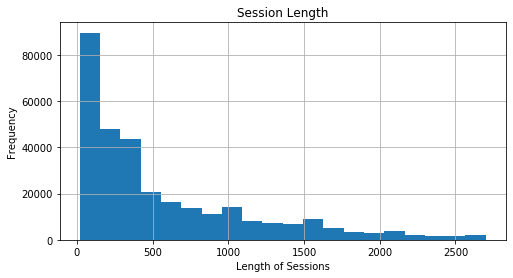

In [43]:
plt.figure(figsize = (8,4));
length_sec['session_duration_sec'].hist(bins = 20).set_title('Session Length');
plt.xlabel('Length of Sessions');
plt.ylabel('Frequency');

- from the hist and the description above we see that we got rid of most of our outliers but the data is still skewed.
- the mean and the median are far from equal with the mean being much higher than the median: 
1. mean = 568 seconds
2. median = 360 seconds

- usually in this case the median will give the better indicator but when we look at our services ( buying tickets should be done fast and smothely with time as short as possible ) we think that we should take into consideration the longer sessions which can point out some unclarity in the way these services are presented.

In [44]:
session_length = length_sec.groupby(['visit_date', 'device'])['session_duration_sec'].mean().reset_index()
session_length['session_duration_min'] = session_length['session_duration_sec'] / 60
session_length.head()

,visit_date,device,session_duration_sec,session_duration_min
0,2017-06-01,desktop,617.726852,10.295448
1,2017-06-01,touch,446.707143,7.445119
2,2017-06-02,desktop,552.724215,9.212070
3,2017-06-02,touch,514.615385,8.576923
4,2017-06-03,desktop,593.961404,9.899357


In [45]:
print('Average Session Length (Desktop):', "{:.2f}".format(
    session_length[session_length['device'] == 'desktop']['session_duration_min'].mean()))
print('Average Session Length (Touch)', "{:.2f}".format(
    session_length[session_length['device'] == 'touch']['session_duration_min'].mean()))

Average Session Length (Desktop): 9.85
Average Session Length (Touch) 7.85


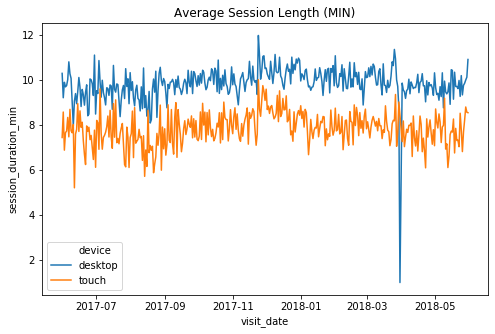

In [46]:
plt.figure(figsize = (8,5));
plt.title('Average Session Length (MIN)');
plt.ylabel('Average Session Length');
plt.xlabel('Date');
sns.lineplot(y='session_duration_min', x ='visit_date', data= session_length, hue='device');

- the average session length is generaly higher on the desktop version (around 9.85 Min) compared to the touch version (around 7.85 Min)
- from the graph it is clear that the average session length doesn't vary nmuch throughout the year on both versions except for the sudden rise on `black friday`  
- we can see that the drop on `31.03.` affected the length only for the desktop version which negates our previous conclusion that the problem was in the server in general and not only in the web version therfore this needs to be further checked with the developers and server team.

#### How often do users come back?

to answer this question we will study the retention and we will base our study on 2 points:
1. cohort "month of registration/ first visit"
2. source_id

In [47]:
visits.head()

,device,visit_end_ts,source_id,visit_start_ts,user_id,visit_date,session_duration_sec,session_duration_min
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,1080,18.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,1680,28.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,0,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,1440,24.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,0,0.0


In [48]:
#cohort forming
first_activity_date = visits.groupby('user_id')['visit_start_ts'].min()
first_activity_date.name = 'first_activity_ts'
retention = visits.join(first_activity_date, on= 'user_id')
retention.head()

,device,visit_end_ts,source_id,visit_start_ts,user_id,visit_date,session_duration_sec,session_duration_min,first_activity_ts
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,1080,18.0,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,1680,28.0,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,0,0.0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,1440,24.0,2018-03-09 20:05:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,0,0.0,2017-12-27 14:06:00


In [49]:
retention['cohort'] = retention['first_activity_ts'].apply(lambda x: x.strftime('%Y-%m'))
retention.head()

,device,visit_end_ts,source_id,visit_start_ts,user_id,visit_date,session_duration_sec,session_duration_min,first_activity_ts,cohort
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,1080,18.0,2017-12-20 17:20:00,2017-12
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,1680,28.0,2018-02-19 16:53:00,2018-02
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,0,0.0,2017-07-01 01:54:00,2017-07
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,1440,24.0,2018-03-09 20:05:00,2018-03
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,0,0.0,2017-12-27 14:06:00,2017-12


In [50]:
retention_2 = retention.copy()

In [51]:
retention['days_till_retention'] = (
    ((retention['visit_start_ts'] - retention['first_activity_ts'])/np.timedelta64(1, 'D')).
    astype('int'))
retention.head()

,device,visit_end_ts,source_id,visit_start_ts,user_id,visit_date,session_duration_sec,session_duration_min,first_activity_ts,cohort,days_till_retention
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,1080,18.0,2017-12-20 17:20:00,2017-12,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,1680,28.0,2018-02-19 16:53:00,2018-02,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,0,0.0,2017-07-01 01:54:00,2017-07,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,1440,24.0,2018-03-09 20:05:00,2018-03,71
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,0,0.0,2017-12-27 14:06:00,2017-12,0


as the retenion is basicaly coming back to the services after the first visit therefore we will exclude the first visit from our data to check only for the second visit and after.

In [52]:
actual_retentions = retention[retention['visit_start_ts']!=retention['first_activity_ts']]
actual_retentions.head()

,device,visit_end_ts,source_id,visit_start_ts,user_id,visit_date,session_duration_sec,session_duration_min,first_activity_ts,cohort,days_till_retention
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,1440,24.0,2018-03-09 20:05:00,2018-03,71
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-30,3360,56.0,2017-06-29 09:00:00,2017-06,215
11,desktop,2018-01-25 19:41:00,1,2018-01-25 19:37:00,7478054213403174082,2018-01-25,240,4.0,2018-01-25 14:16:00,2018-01,0
12,desktop,2018-02-06 15:50:00,4,2018-02-06 15:45:00,8056418121947262981,2018-02-06,300,5.0,2017-06-04 14:17:00,2017-06,247
14,touch,2018-04-23 18:01:00,9,2018-04-23 18:00:00,18026419100367255411,2018-04-23,60,1.0,2017-10-04 22:44:00,2017-10,200


In [53]:
def retention_generator(ret_group, ret_for):
    ret_grouped = ((actual_retentions.query('days_till_retention ==@ret_group')
                   .groupby(ret_for)['user_id'].nunique()) /
                  retention.groupby(ret_for)['user_id'].nunique()) * 100
    ret_grouped = ret_grouped.reset_index().rename(columns= {'user_id': 'retention{}d'.format(ret_group)})
    return ret_grouped

In [54]:
retention_by_source = []
retention_by_cohort = []
retention_list = [0,1,3,7,14,30,60]
for i in retention_list:
    retention_by_source.append(retention_generator(i, 'source_id'))
    retention_by_cohort.append(retention_generator(i, 'cohort'))

In [55]:
retention_by_cohort = pd.concat(retention_by_cohort, axis=1)
retention_by_cohort = retention_by_cohort.loc[:,~retention_by_cohort.columns.duplicated()]
retention_by_cohort

,cohort,retention0d,retention1d,retention3d,retention7d,retention14d,retention30d,retention60d
0,2017-06,6.252357,1.772381,1.153933,0.822083,0.739121,0.377102,0.392186
1,2017-07,6.004566,1.811263,0.859970,0.555556,0.418569,0.235921,0.205479
2,2017-08,4.655731,1.109911,0.775955,0.559866,0.373244,0.255378,0.284844
3,2017-09,5.806992,1.466715,0.915948,0.562739,0.610632,0.293343,0.329262
4,2017-10,6.317127,1.724603,0.962390,0.646726,0.612080,0.327213,0.269469
5,2017-11,7.116119,2.286406,1.284498,0.891809,0.664269,0.260570,0.216530
6,2017-12,6.225265,1.697800,1.068545,0.633212,0.427418,0.257242,0.158303
7,2018-01,5.582567,1.622171,0.879597,0.530410,0.380127,0.198904,0.159123
8,2018-02,5.626887,1.522728,0.896518,0.608190,0.396450,0.216245,0.121638
9,2018-03,6.231483,1.568799,0.655690,0.427413,0.305989,0.155423,0.116567


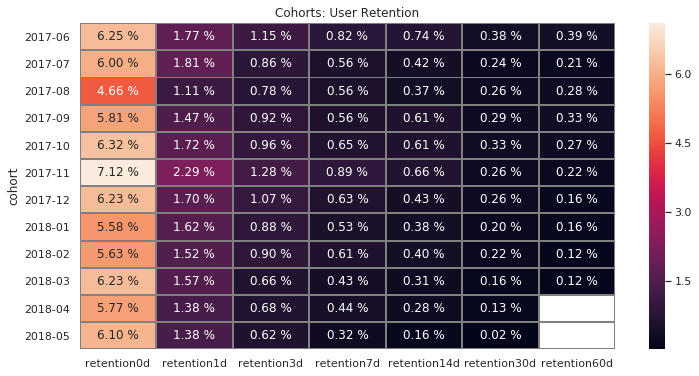

In [56]:
sns.set(style='white')
plt.figure(figsize=(12, 6))
plt.title('Cohorts: User Retention')
ax = sns.heatmap(retention_by_cohort.set_index('cohort'), annot=True, fmt='.2f', linewidths=1, linecolor='gray') ;
for t in ax.texts: t.set_text(t.get_text() + " %")

In [57]:
retention_by_source = pd.concat(retention_by_source, axis=1)
retention_by_source = retention_by_source.loc[:,~retention_by_source.columns.duplicated()]
retention_by_source

,source_id,retention0d,retention1d,retention3d,retention7d,retention14d,retention30d,retention60d
0,1,23.238065,4.837097,2.115901,1.173746,0.894784,0.368440,0.284225
1,2,8.089160,3.036769,1.908935,1.280244,0.944942,0.419127,0.350543
2,3,2.252662,0.865482,0.445449,0.258173,0.228744,0.144470,0.107015
3,4,2.818318,1.115834,0.658485,0.454954,0.312481,0.173601,0.143670
4,5,6.518763,0.909187,0.549373,0.321199,0.254502,0.133394,0.086004
5,6,16.666667,NaN,NaN,NaN,NaN,NaN,NaN
6,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,9,1.835060,1.014680,0.928325,0.982297,0.993092,0.334629,0.356218
8,10,4.351060,1.648692,0.805752,0.334697,0.285112,0.136358,0.161150


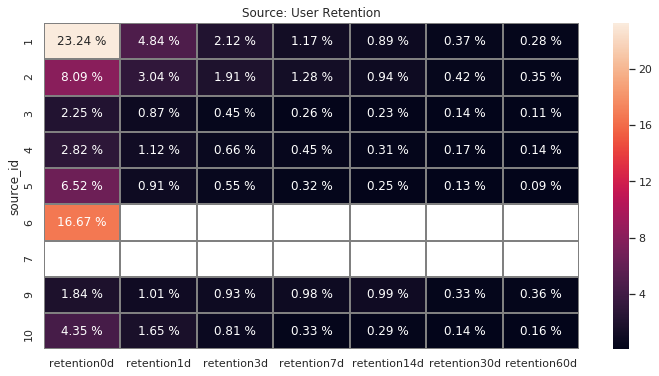

In [58]:
sns.set(style='white')
plt.figure(figsize=(12, 6))
plt.title('Source: User Retention')
ax = sns.heatmap(retention_by_source.set_index('source_id'), annot=True, fmt='.2f', linewidths=1, linecolor='gray') ;
for t in ax.texts: t.set_text(t.get_text() + " %")

- from the heatmaps above we can see that the users don't return to the services that often and in general the highest retention is usualy in the same day as the registration or the next day (0d or 1d) and then the retention rate drops noticably.
- the retention rate is not affected by the cohort as all of them have the same retention:  
6% on the 0d - 1.5% on the 1d and then it drops below 1%
- based on the source we notice that the source_id '1' has an incredible retention rate (23%) on the '0d' but after that it drops drasticaly to be on par with the other sources. this should be studied more as there might be a hint or something that trigers this high retention rate.

In [59]:
retention_2['activity_month'] = retention_2['visit_date'].astype('datetime64[M]')
retention_2['first_activity_month'] = retention_2['first_activity_ts'].astype('datetime64[M]')

retention_2.head()

,device,visit_end_ts,source_id,visit_start_ts,user_id,visit_date,session_duration_sec,session_duration_min,first_activity_ts,cohort,activity_month,first_activity_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,1080,18.0,2017-12-20 17:20:00,2017-12,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,1680,28.0,2018-02-19 16:53:00,2018-02,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,0,0.0,2017-07-01 01:54:00,2017-07,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,1440,24.0,2018-03-09 20:05:00,2018-03,2018-05-01,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,0,0.0,2017-12-27 14:06:00,2017-12,2017-12-01,2017-12-01


In [60]:
retention_2['cohort_lifetime'] = ( retention_2['activity_month'] - retention_2['first_activity_month'] ) 
retention_2['cohort_lifetime'] = retention_2[ 'cohort_lifetime' ] / np.timedelta64(1, 'M') 
retention_2['cohort_lifetime'] = retention_2['cohort_lifetime'].round().astype(int)
retention_2.head()

,device,visit_end_ts,source_id,visit_start_ts,user_id,visit_date,session_duration_sec,session_duration_min,first_activity_ts,cohort,activity_month,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,1080,18.0,2017-12-20 17:20:00,2017-12,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,1680,28.0,2018-02-19 16:53:00,2018-02,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,0,0.0,2017-07-01 01:54:00,2017-07,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,1440,24.0,2018-03-09 20:05:00,2018-03,2018-05-01,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,0,0.0,2017-12-27 14:06:00,2017-12,2017-12-01,2017-12-01,0


In [61]:
cohorts_2 = retention_2.groupby(['first_activity_month','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index()
cohorts_2

,first_activity_month,cohort_lifetime,user_id
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


In [62]:
initial_users_count = cohorts_2[cohorts_2['cohort_lifetime'] == 0][['first_activity_month', 'user_id']]
initial_users_count = initial_users_count.rename(columns={'user_id': 'cohort_users'}) 
initial_users_count

,first_activity_month,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


In [63]:
cohorts_2 = cohorts_2.merge(initial_users_count, on='first_activity_month')
cohorts_2

,first_activity_month,cohort_lifetime,user_id,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259
...,...,...,...,...
73,2018-03-01,1,861,20589
74,2018-03-01,2,557,20589
75,2018-04-01,0,15709,15709
76,2018-04-01,1,760,15709


In [64]:
cohorts_2['retention'] = cohorts_2['user_id'] / cohorts_2['cohort_users']
cohorts_2

,first_activity_month,cohort_lifetime,user_id,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557
...,...,...,...,...,...
73,2018-03-01,1,861,20589,0.041818
74,2018-03-01,2,557,20589,0.027053
75,2018-04-01,0,15709,15709,1.000000
76,2018-04-01,1,760,15709,0.048380


In [65]:
retention_2_pivot = cohorts_2.pivot_table(
    index='first_activity_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)
retention_2_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


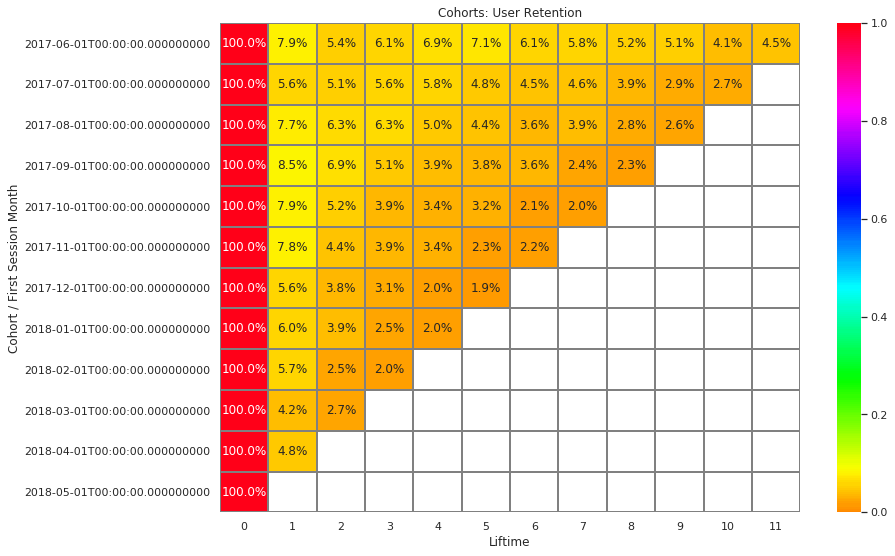

In [66]:
#sns.set(style='dark')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_2_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap="hsv", center = 0.45
            , vmin=0 , vmax= 1);
plt.ylabel('Cohort / First Session Month');
plt.xlabel('Liftime');

- by using another algorithem for retention by Cohort/Month we see that the retention rate doesn't even reach 8% in any month/Liftime for any cohort
- the retention rate seems to be the same for all cohorts over their lifetime and ranges between 2 - 8% 

### 2. Sales:
now lets start the next part of our study about the sales:

<br>

#### When do people start buying?

to answer this questiun we will analyze and calculate the conversion rates based on cohort:

In [67]:
orders.head()

,order_ts,revenue,user_id
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [68]:
# creating and adding first purchase timestamp for every user and order date
first_purchase_date = orders.groupby('user_id')['order_ts'].min()
first_purchase_date.name = 'first_purchase_ts'
orders = orders.join(first_purchase_date, on= 'user_id')
orders['order_date'] = orders['order_ts'].dt.date
orders.head()

,order_ts,revenue,user_id,first_purchase_ts,order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01


In [69]:
# forming cohorts
first_purchase = orders.merge(right= first_activity_date, how= 'left', on='user_id')
first_purchase['cohort'] = first_purchase['first_activity_ts'].apply(lambda x: x.strftime('%Y-%m'))
first_purchase.head()

,order_ts,revenue,user_id,first_purchase_ts,order_date,first_activity_ts,cohort
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01 00:09:00,2017-06
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01 00:14:00,2017-06
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01 00:25:00,2017-06
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01 00:14:00,2017-06
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01 07:31:00,2017-06


In [70]:
first_purchase['days_before_purchase'] = (
    ((first_purchase['order_ts'] - first_purchase['first_activity_ts'])/np.timedelta64(1, 'D')).
    astype('int'))
first_purchase.head()

,order_ts,revenue,user_id,first_purchase_ts,order_date,first_activity_ts,cohort,days_before_purchase
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01 00:09:00,2017-06,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01 00:14:00,2017-06,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01 00:25:00,2017-06,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01 00:14:00,2017-06,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01 07:31:00,2017-06,0


as the conversion happens only when the user purchase for the first time after registeration/first visist therefore we will need to exclude the second purchases and after 

In [71]:
real_conversion = first_purchase.groupby('user_id')['days_before_purchase'].min()
real_conversion.name = 'days_before_conversion'
real_conversion.head()

user_id
313578113262317     106
1575281904278712      0
2429014661409475      0
2464366381792757      0
2551852515556206      0
Name: days_before_conversion, dtype: int64

In [72]:
first_purchase = first_purchase.join(real_conversion, on='user_id')
first_purchase.head()

,order_ts,revenue,user_id,first_purchase_ts,order_date,first_activity_ts,cohort,days_before_purchase,days_before_conversion
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01 00:09:00,2017-06,0,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01 00:14:00,2017-06,0,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01 00:25:00,2017-06,0,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01 00:14:00,2017-06,0,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01 07:31:00,2017-06,0,0


In [73]:
def conversion_generator(conversion_list, conversion_for):
    conversion_grouped_list = []
    for i in conversion_list:
        conversion_grouped = (((first_purchase.query('days_before_conversion <=@i')
                       .groupby(conversion_for)['user_id'].nunique()) /
                      retention.groupby(conversion_for)['user_id'].nunique()) * 100)
        conversion_grouped_list.append(conversion_grouped.reset_index()
            .rename(columns= {'user_id': 'conversion{}%'.format(i)}))
    return conversion_grouped_list

In [74]:
conversion_list = [0,1,3,7,14,30,60]
conversion_by_cohort = conversion_generator(conversion_list, 'cohort')

In [75]:
conversion_by_cohort = pd.concat(conversion_by_cohort, axis=1)
conversion_by_cohort = conversion_by_cohort.loc[:,~conversion_by_cohort.columns.duplicated()]
conversion_by_cohort

,cohort,conversion0%,conversion1%,conversion3%,conversion7%,conversion14%,conversion30%,conversion60%
0,2017-06,13.605853,14.020665,14.480730,14.948337,15.325439,16.057018,16.743344
1,2017-07,11.613394,12.062405,12.488584,12.960426,13.340944,13.744292,14.436834
2,2017-08,10.774973,11.040173,11.295551,11.727728,12.042039,12.670661,13.505550
3,2017-09,11.769636,12.194684,12.667625,13.302203,13.799090,14.661159,15.541188
4,2017-10,12.711245,13.165493,13.658236,14.147130,14.574431,15.278901,16.148901
5,2017-11,10.518203,11.050352,11.556812,12.041251,12.639460,13.336759,14.096447
6,2017-12,11.841064,12.335761,12.846288,13.376603,13.796106,14.306633,14.987336
7,2018-01,10.281117,10.696605,11.098833,11.549682,11.907709,12.482320,13.127652
8,2018-02,11.181691,11.609677,12.123260,12.654863,13.019777,13.515340,13.889264
9,2018-03,11.506144,11.899558,12.215261,12.569819,12.904949,13.308077,13.633494


- from the table above we can see that the conversion happens mostly on the same day of the registration (10 - 13% converted on the same day and the percentage of converted customers has risen only by 2 - 3% after 60 days )
- we can see that the conversion rates are not high that after around 60 days only 16 % at most of every cohort has converted and the rest either converted later on or stayed as visitors and never purchased anything.
- there isn't a big difference in conversion between cohorts but the april 2018 cohort has relativly low conversion rate compared to the others.

#### How many orders do they make during a given period of time?

In [76]:
first_purchase.head()

,order_ts,revenue,user_id,first_purchase_ts,order_date,first_activity_ts,cohort,days_before_purchase,days_before_conversion
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01 00:09:00,2017-06,0,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01 00:14:00,2017-06,0,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01 00:25:00,2017-06,0,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01 00:14:00,2017-06,0,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01 07:31:00,2017-06,0,0


In [77]:
orders_per_date = first_purchase.groupby('order_date')['user_id'].count().reset_index()
orders_per_date = orders_per_date.rename(columns={'user_id': 'orders_count'})
orders_per_date.head()

,order_date,orders_count
0,2017-06-01,96
1,2017-06-02,111
2,2017-06-03,67
3,2017-06-04,66
4,2017-06-05,161


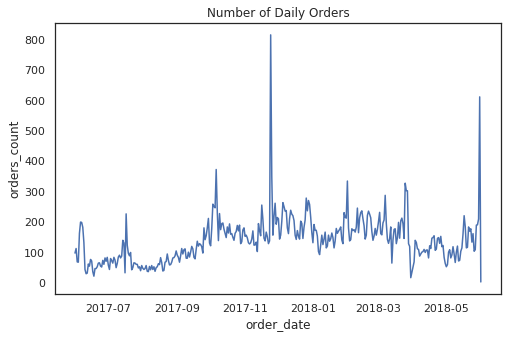

In [78]:
plt.figure(figsize = (8,5));
plt.title('Number of Daily Orders');
plt.ylabel('Orders Count');
plt.xlabel('Date');
sns.lineplot(y='orders_count', x ='order_date', data= orders_per_date);

- we can see that the number of orders has risen in the winter
- number of orders in general ranges between 150 - 250 daily orders
- we can notice a few spike in number of orders which are most probably in the start of the month when people recieve their wages and the most obvious spike was again in the end of november and probably on `black friday`

In [79]:
cohort_orders_per_date = first_purchase.groupby(['order_date', 'cohort'])['user_id'].count().reset_index()
cohort_orders_per_date = cohort_orders_per_date.rename(columns={'user_id': 'orders_count'})
cohort_orders_per_date.head()

,order_date,cohort,orders_count
0,2017-06-01,2017-06,96
1,2017-06-02,2017-06,111
2,2017-06-03,2017-06,67
3,2017-06-04,2017-06,66
4,2017-06-05,2017-06,161


In [80]:
average_daily_orders_cohort = cohort_orders_per_date.groupby('cohort')['orders_count'].mean().reset_index()
average_daily_orders_cohort

,cohort,orders_count
0,2017-06,17.671271
1,2017-07,10.807927
2,2017-08,9.159722
3,2017-09,16.462121
4,2017-10,26.189076
5,2017-11,28.764423
6,2017-12,29.920000
7,2018-01,26.285714
8,2018-02,33.327586
9,2018-03,39.831461


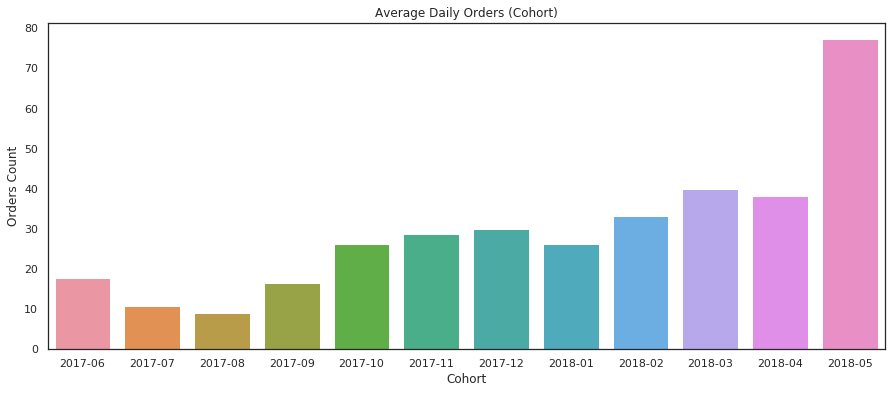

In [81]:
plt.figure(figsize=(15,6))
sns.barplot(y= 'orders_count', x='cohort' ,data = average_daily_orders_cohort).set_title(
    'Average Daily Orders (Cohort)');
plt.xlabel('Cohort');
plt.ylabel('Orders Count');

- when comparing the average daily orders based on cohorts then we will notice that the number of orders are generaly increasing with every cohort but they still have an average of 30 daily orders which is when summed together will match the average we concluded from the our previous lineplot 
- the increase in number of daily orders in the later cohorts can be explained that usualy the new costumers register to buy therefore the number of orders for the new cohorts will be naturaly higher than the older but we will therefore we will need to later analysis to proof this point.

In [82]:
orders_2 = first_purchase.copy()
orders_2.head()

,order_ts,revenue,user_id,first_purchase_ts,order_date,first_activity_ts,cohort,days_before_purchase,days_before_conversion
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01 00:09:00,2017-06,0,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01 00:14:00,2017-06,0,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01 00:25:00,2017-06,0,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01 00:14:00,2017-06,0,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01 07:31:00,2017-06,0,0


In [83]:
orders_2['order_month'] = orders_2['order_date'].astype('datetime64[M]')
orders_2['order_week'] = orders_2['order_date'].astype('datetime64[W]')
orders_2.head()

,order_ts,revenue,user_id,first_purchase_ts,order_date,first_activity_ts,cohort,days_before_purchase,days_before_conversion,order_month,order_week
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01 00:09:00,2017-06,0,0,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01 00:14:00,2017-06,0,0,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01 00:25:00,2017-06,0,0,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01 00:14:00,2017-06,0,0,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01 07:31:00,2017-06,0,0,2017-06-01,2017-06-01


In [84]:
monthly_orders_user = orders_2.groupby(['user_id', 'order_month'])['order_ts'].count().reset_index().rename(columns = {'order_ts': 'orders_count'})
monthly_orders = orders_2.groupby(['order_month'])['order_ts'].count().reset_index().rename(columns = {'order_ts': 'orders_count'})
weekly_orders = orders_2.groupby(['order_week'])['order_ts'].count().reset_index().rename(columns = {'order_ts': 'orders_count'})
daily_orders = orders_2.groupby(['order_date'])['order_ts'].count().reset_index().rename(columns = {'order_ts': 'orders_count'})

In [85]:
display(monthly_orders)
display(weekly_orders.head())
daily_orders.head()

,order_month,orders_count
0,2017-06-01,2354
1,2017-07-01,2363
2,2017-08-01,1807
3,2017-09-01,3387
4,2017-10-01,5679
5,2017-11-01,5659
6,2017-12-01,6218
7,2018-01-01,4721
8,2018-02-01,5281
9,2018-03-01,5326


,order_week,orders_count
0,2017-06-01,896
1,2017-06-08,525
2,2017-06-15,341
3,2017-06-22,441
4,2017-06-29,461


,order_date,orders_count
0,2017-06-01,96
1,2017-06-02,111
2,2017-06-03,67
3,2017-06-04,66
4,2017-06-05,161


In [86]:
monthly_orders['order_month'] = monthly_orders['order_month'].apply(lambda x: x.strftime('%Y-%m'))

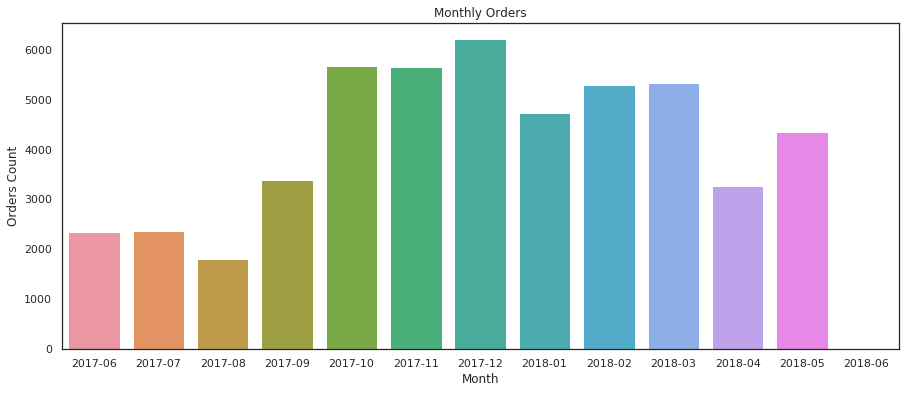

In [87]:
plt.figure(figsize=(15,6))
sns.barplot(y= 'orders_count', x='order_month' ,data = monthly_orders).set_title('Monthly Orders');
plt.xticks()
plt.xlabel('Month');
plt.ylabel('Orders Count');

In [88]:
print('Average Monthly Orders:', '{:.0f}'.format(monthly_orders['orders_count'].mean()))

Average Monthly Orders: 3878


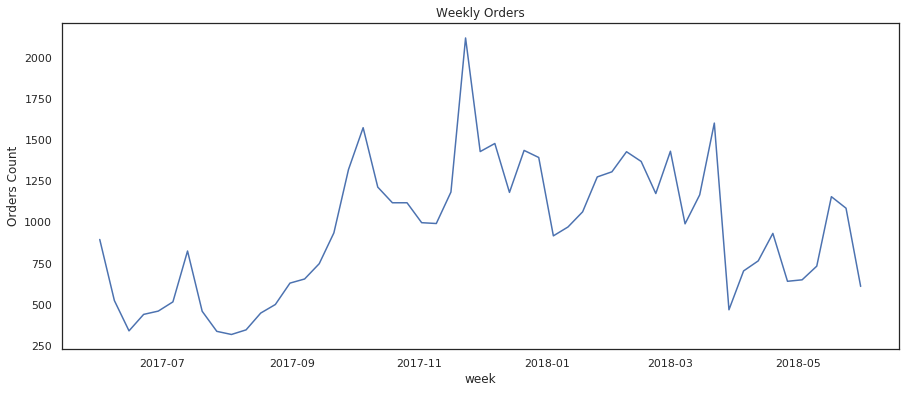

In [89]:
plt.figure(figsize=(15,6))
sns.lineplot(y= 'orders_count', x='order_week' ,data = weekly_orders).set_title('Weekly Orders');
plt.xlabel('week');
plt.ylabel('Orders Count');

In [90]:
print('Average Weekly Orders:', '{:.0f}'.format(weekly_orders['orders_count'].mean()))

Average Weekly Orders: 951


In [91]:
daily_orders[daily_orders['orders_count'] == daily_orders['orders_count'].max()]

,order_date,orders_count
176,2017-11-24,814


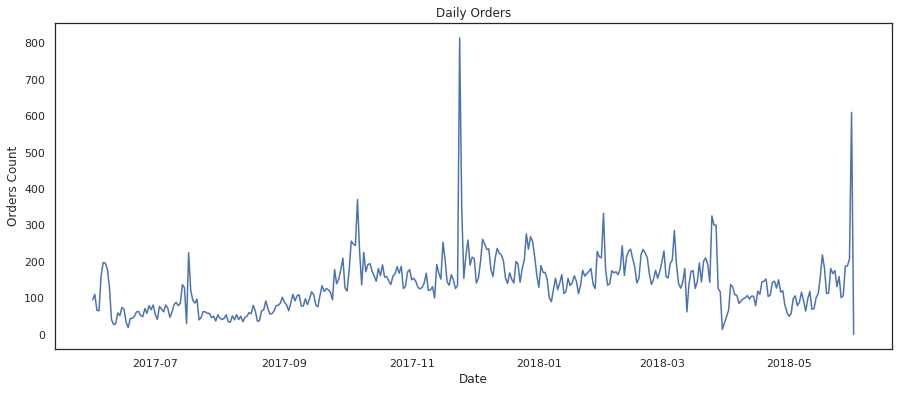

In [92]:
plt.figure(figsize=(15,6))
sns.lineplot(y= 'orders_count', x='order_date' ,data = daily_orders).set_title('Daily Orders');
plt.xlabel('Date');
plt.ylabel('Orders Count');

In [93]:
print('Average Daily Orders:', '{:.0f}'.format(daily_orders['orders_count'].mean()))

Average Daily Orders: 139


In [94]:
monthly_user_grouped = monthly_orders_user.set_index('order_month')
monthly_user_grouped.head()

,user_id,orders_count
order_month,,
2018-01-01,313578113262317,1
2017-06-01,1575281904278712,2
2017-10-01,2429014661409475,1
2018-01-01,2464366381792757,1
2017-11-01,2551852515556206,2


In [95]:
start_time = time.time()
orders_over_6_month = monthly_user_grouped.groupby('user_id')['orders_count'].resample('6M').sum()
print(f'time needed: {time.time() - start_time}')   

time needed: 170.27792835235596


In [96]:
orders_over_6_month.head()

user_id           order_month
313578113262317   2018-01-31     1
1575281904278712  2017-06-30     2
2429014661409475  2017-10-31     1
2464366381792757  2018-01-31     1
2551852515556206  2017-11-30     2
Name: orders_count, dtype: int64

In [97]:
average_6_month_user = orders_over_6_month.reset_index().groupby('user_id')['orders_count'].mean().reset_index()
average_6_month_user.head()

,user_id,orders_count
0,313578113262317,1.0
1,1575281904278712,2.0
2,2429014661409475,1.0
3,2464366381792757,1.0
4,2551852515556206,2.0


In [98]:
print('Average Orders per User Over 6 Months:', '{:.2f}'.format(average_6_month_user['orders_count'].mean()))

Average Orders per User Over 6 Months: 1.18


- from the graphs above we notice that the number of orders rises noticably in the winter time in comparision to the summer
- the most orders were made in December 2017 and reached over 6000 orders. 
- number of orders in general ranges between 150 - 250 daily orders
- we can notice a few spike in number of orders which are most probably in the start of the month when people recieve their wages and the most obvious spike was again in the end of november and probably on `black friday`

the average number of orders are as follows: 
1. monthly: 3878
2. weekly: 951
3. daily: 139 

we can also notice that every user makes on average 1.18 orders every 6 months

#### What is the average purchase size?

In [99]:
average_orders = first_purchase.groupby('order_date')['revenue'].mean().reset_index()
average_orders = average_orders.rename(columns={'revenue': 'average_revenue'})
average_orders.head()

,order_date,average_revenue
0,2017-06-01,4.056875
1,2017-06-02,2.919910
2,2017-06-03,2.484776
3,2017-06-04,2.957727
4,2017-06-05,2.742174


In [100]:
print('Average Revenue per Purchase:', "{:.2f}".format(average_orders['average_revenue'].mean()))

Average Revenue per Purchase: 4.94


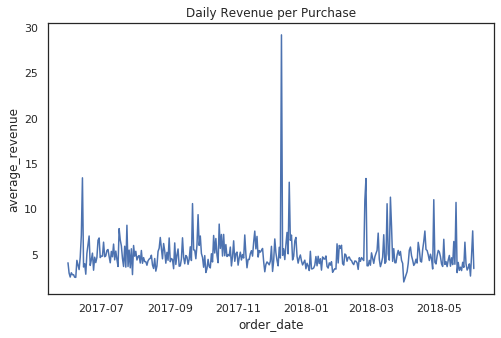

In [101]:
plt.figure(figsize = (8,5));
plt.title('Daily Revenue per Purchase');
plt.ylabel('Revenue');
plt.xlabel('Date');
sns.lineplot(y='average_revenue', x ='order_date', data= average_orders);

- from the graph above we can see that the daily average revenue per Order ranges around 5 USD.
- we can see some big spikes in the daily average revenue per Order where it reaches 12 - 15 USD and this is probably due to a holiday or a special event that was particularly popular.
- the end of november witnessed again a huge rise in the sales where the average revenue per Order reached around 30 USD on `Black Friday`

In [102]:
average_orders_cohort = first_purchase.groupby('cohort')['revenue'].mean().reset_index()
average_orders_cohort = average_orders_cohort.rename(columns={'revenue': 'average_purchase_size'})
average_orders_cohort

,cohort,average_purchase_size
0,2017-06,6.257003
1,2017-07,5.024573
2,2017-08,5.103059
3,2017-09,7.750244
4,2017-10,4.469387
5,2017-11,4.082688
6,2017-12,5.950697
7,2018-01,3.764705
8,2018-02,3.895833
9,2018-03,3.884389


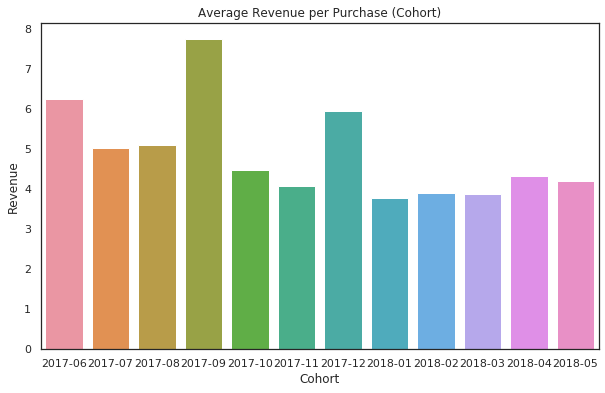

In [103]:
plt.figure(figsize = (10,6));
plt.title('Average Revenue per Purchase (Cohort)');
sns.barplot(y='average_purchase_size', x ='cohort', data= average_orders_cohort);
plt.ylabel('Revenue');
plt.xlabel('Cohort');

when we study the average revenue per order based on cohort we see that the average ranges between 4 - 6 USD per order with the exception of the september 2017 cohort where they have a higher average that reaches 8 USD per order.

#### How much money do they bring? (LTV)

<br>

to study the LTV we will start by calculating the average user revenue per cohort

In [104]:
revenue_per_user_cohort = first_purchase.groupby(['cohort', 'user_id'])['revenue'].sum().reset_index()
revenue_per_user_cohort.head()

,cohort,user_id,revenue
0,2017-06,1575281904278712,3.05
1,2017-06,16233238570251706,1.65
2,2017-06,28094489227360733,8.41
3,2017-06,29085576454138824,3.36
4,2017-06,29340056013621514,1.04


In [105]:
average_revenue_user_cohort = revenue_per_user_cohort.groupby('cohort')['revenue'].mean().reset_index()
average_revenue_user_cohort = average_revenue_user_cohort.rename(columns={'revenue': 'AVG_Revenue'})
average_revenue_user_cohort

,cohort,AVG_Revenue
0,2017-06,13.693483
1,2017-07,7.246587
2,2017-08,7.822121
3,2017-09,11.014572
4,2017-10,5.955043
5,2017-11,5.731281
6,2017-12,7.647975
7,2018-01,4.663937
8,2018-02,4.727335
9,2018-03,4.852065


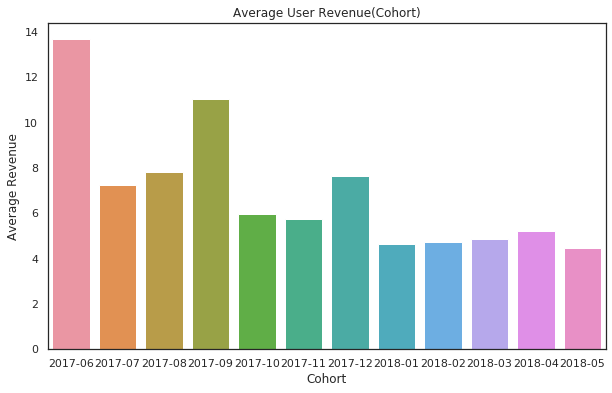

In [106]:
plt.figure(figsize = (10,6));
plt.title('Average User Revenue(Cohort)');
sns.barplot(y='AVG_Revenue', x ='cohort', data= average_revenue_user_cohort);
plt.ylabel('Average Revenue');
plt.xlabel('Cohort');

we see from the graph above that the average user revenue doesn't vary much between cohorts and ranges between 4-6 USD with exception of the (June 2017) and (september 2017) cohorts which reach 11 and 14 USD respectively.

now lets calculate the LTV and we will start by adding the lifetime column to our data

In [107]:
first_purchase['liftime'] = (first_purchase['days_before_purchase'] / 30).round()
first_purchase.head()

,order_ts,revenue,user_id,first_purchase_ts,order_date,first_activity_ts,cohort,days_before_purchase,days_before_conversion,liftime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01 00:09:00,2017-06,0,0,0.0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01 00:14:00,2017-06,0,0,0.0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01 00:25:00,2017-06,0,0,0.0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01 00:14:00,2017-06,0,0,0.0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01 07:31:00,2017-06,0,0,0.0


In [108]:
# general monthly LTV by cohort
ltv = first_purchase.pivot_table(index = 'cohort', columns = 'liftime',
                                 values='revenue', aggfunc='sum')
ltv

liftime,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
cohort,,,,,,,,,,,,,
2017-06,9484.94,2301.57,1456.55,2716.09,4497.07,2551.95,3836.70,1937.56,2541.73,3422.92,2028.35,2423.00,827.62
2017-07,9959.81,868.49,1181.01,925.52,852.40,761.67,602.66,827.69,758.58,496.46,368.23,209.59,NaN
2017-08,6433.70,907.02,986.76,972.82,715.88,515.12,587.51,997.35,979.88,315.71,50.12,NaN,NaN
2017-09,12889.63,3011.82,2138.91,9665.81,2213.95,1963.53,765.91,603.81,330.25,98.94,NaN,NaN,NaN
2017-10,18658.04,3100.53,1793.21,873.71,1280.60,878.61,504.53,638.55,129.91,NaN,NaN,NaN,NaN
2017-11,17199.63,2050.79,1573.24,1171.34,1064.26,667.16,629.31,70.99,NaN,NaN,NaN,NaN,NaN
2017-12,16806.11,1644.91,4397.69,4952.51,1670.38,1612.26,73.99,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,11020.59,1614.04,1089.23,339.28,422.03,61.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,11752.38,1682.89,745.18,711.10,169.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


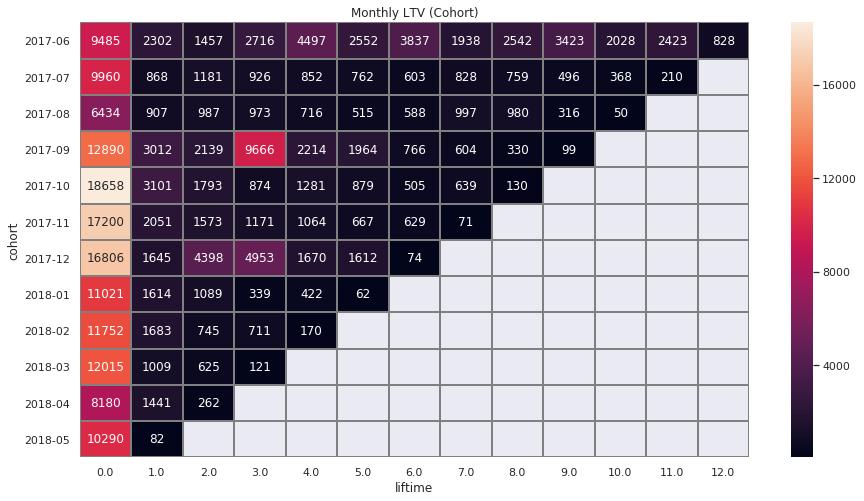

In [109]:
sns.set(style='dark')
plt.figure(figsize=(15, 8))
plt.title('Monthly LTV (Cohort)')
sns.heatmap(ltv, annot=True, fmt='.0f', linewidths=1, linecolor='gray') ;

- it is obvious from the graph above that the monthly revenue reaches its peak in the 0th liftime for every cohort and then drops drasticaly to less than quarter of the first month.
- after the initial drop the monthly revenue will fluctuate every month but will never reach half the revenue of the first month with the exception of the 3rd month of the lifetime for the (september 2017) cohort where it reached 3 quarters of the first months revenue.

In [110]:
# cumulative LTV by cohort
ltv_cumulative = ltv.cumsum(axis = 1)
ltv_cumulative

liftime,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
cohort,,,,,,,,,,,,,
2017-06,9484.94,11786.51,13243.06,15959.15,20456.22,23008.17,26844.87,28782.43,31324.16,34747.08,36775.43,39198.43,40026.05
2017-07,9959.81,10828.30,12009.31,12934.83,13787.23,14548.90,15151.56,15979.25,16737.83,17234.29,17602.52,17812.11,NaN
2017-08,6433.70,7340.72,8327.48,9300.30,10016.18,10531.30,11118.81,12116.16,13096.04,13411.75,13461.87,NaN,NaN
2017-09,12889.63,15901.45,18040.36,27706.17,29920.12,31883.65,32649.56,33253.37,33583.62,33682.56,NaN,NaN,NaN
2017-10,18658.04,21758.57,23551.78,24425.49,25706.09,26584.70,27089.23,27727.78,27857.69,NaN,NaN,NaN,NaN
2017-11,17199.63,19250.42,20823.66,21995.00,23059.26,23726.42,24355.73,24426.72,NaN,NaN,NaN,NaN,NaN
2017-12,16806.11,18451.02,22848.71,27801.22,29471.60,31083.86,31157.85,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,11020.59,12634.63,13723.86,14063.14,14485.17,14546.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,11752.38,13435.27,14180.45,14891.55,15061.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


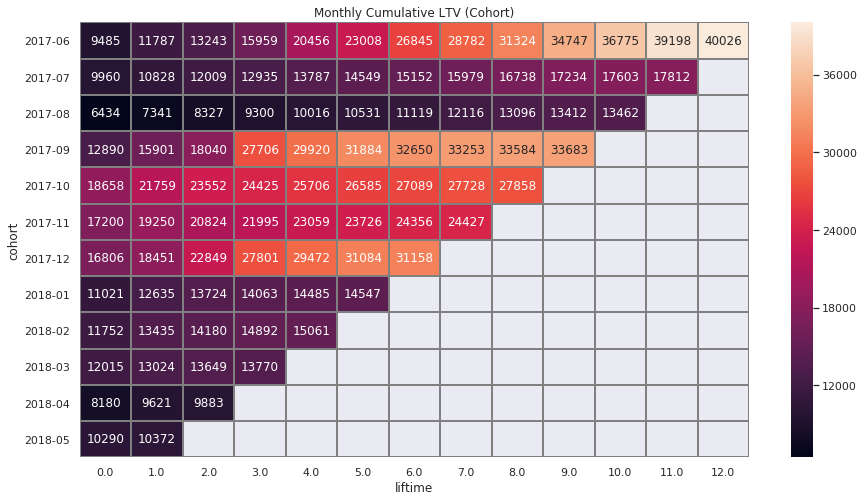

In [111]:
sns.set(style='dark')
plt.figure(figsize=(15, 8))
plt.title('Monthly Cumulative LTV (Cohort)')
sns.heatmap(ltv_cumulative, annot=True, fmt='.0f', linewidths=1, linecolor='gray') ;
# for t in ax.texts: t.set_text(t.get_text() + " %")

- from the the cumulative LTV above we can see that the (June 2017) generated the most revenue of all the cohorts.
- the cumulative LTV varied alot between cohorts and the least profitable cohorts were (July 2017) and (August 2017) which barely generated half the revenue of the next 4 cohorts despite having more time in their lifetime.   
- (September 2017) and (December 2017) looks promising as they generated as much Revenue or more than the (June 2017) cohort in their respective monthly lifetime.

In [112]:
# number of mobthly buyers by cohort
number_of_buyers = first_purchase.pivot_table(index = 'cohort', columns = 'liftime',
                                 values='user_id', aggfunc='nunique')
number_of_buyers

liftime,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
cohort,,,,,,,,,,,,,
2017-06,2034.0,208.0,140.0,164.0,251.0,186.0,200.0,143.0,181.0,151.0,120.0,123.0,85.0
2017-07,1756.0,121.0,158.0,136.0,144.0,135.0,126.0,126.0,121.0,70.0,66.0,28.0,NaN
2017-08,1232.0,130.0,128.0,117.0,100.0,71.0,94.0,67.0,57.0,50.0,14.0,NaN,NaN
2017-09,2315.0,299.0,235.0,154.0,133.0,141.0,134.0,73.0,79.0,17.0,NaN,NaN,NaN
2017-10,3802.0,403.0,305.0,202.0,216.0,161.0,117.0,110.0,28.0,NaN,NaN,NaN,NaN
2017-11,3458.0,406.0,265.0,192.0,186.0,111.0,114.0,22.0,NaN,NaN,NaN,NaN,NaN
2017-12,3495.0,291.0,226.0,158.0,110.0,93.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,2705.0,259.0,166.0,84.0,76.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,2901.0,218.0,114.0,80.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
# average monthly ltv by cohort
ltv_mean = ltv / number_of_buyers
ltv_mean = average_revenue_user_cohort.merge(ltv_mean, on='cohort', how='left').set_index('cohort')
ltv_mean

,AVG_Revenue,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
cohort,,,,,,,,,,,,,,
2017-06,13.693483,4.663196,11.065240,10.403929,16.561524,17.916614,13.720161,19.183500,13.549371,14.042707,22.668344,16.902917,19.699187,9.736706
2017-07,7.246587,5.671874,7.177603,7.474747,6.805294,5.919444,5.642000,4.783016,6.568968,6.269256,7.092286,5.579242,7.485357,NaN
2017-08,7.822121,5.222159,6.977077,7.709063,8.314701,7.158800,7.255211,6.250106,14.885821,17.190877,6.314200,3.580000,NaN,NaN
2017-09,11.014572,5.567875,10.072977,9.101745,62.765000,16.646241,13.925745,5.715746,8.271370,4.180380,5.820000,NaN,NaN,NaN
2017-10,5.955043,4.907428,7.693623,5.879377,4.325297,5.928704,5.457205,4.312222,5.805000,4.639643,NaN,NaN,NaN,NaN
2017-11,5.731281,4.973866,5.051207,5.936755,6.100729,5.721828,6.010450,5.520263,3.226818,NaN,NaN,NaN,NaN,NaN
2017-12,7.647975,4.808615,5.652612,19.458805,31.345000,15.185273,17.336129,2.551379,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.663937,4.074155,6.231815,6.561627,4.039048,5.553026,6.850000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.727335,4.051148,7.719679,6.536667,8.888750,6.789600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


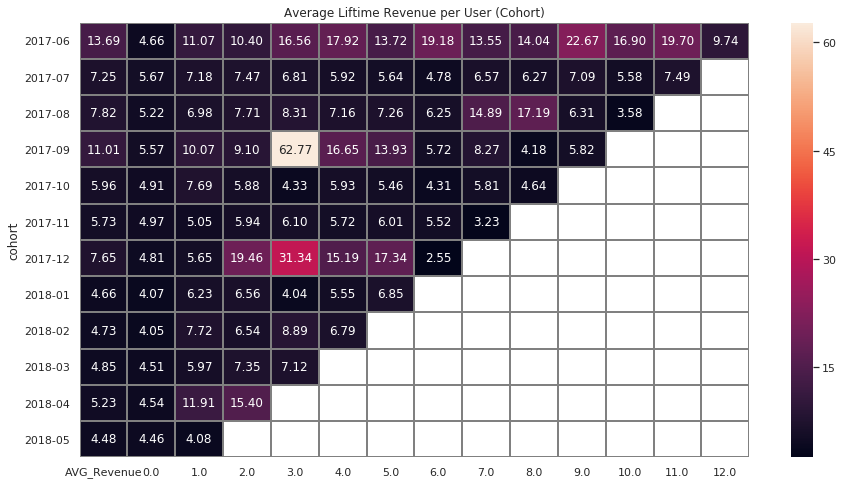

In [114]:
sns.set(style='white')
plt.figure(figsize=(15, 8))
plt.title('Average Liftime Revenue per User (Cohort)')
sns.heatmap(ltv_mean, annot=True, fmt='.2f', linewidths=1, linecolor='gray');

in the heat map above we can compare the average user revenue with the average monthly revenue per user for every cohort and we can see that with the exception of the (June 2017) Cohort and a few other months the average monthly revenue per user didn't reach the average user revenue for the same cohort.

In [115]:
orders.head()

,order_ts,revenue,user_id,first_purchase_ts,order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01


In [116]:
orders_ltv = orders.copy()

In [117]:
orders_ltv['order_month'] = orders_ltv['order_date'].astype('datetime64[M]')
orders_ltv['first_order_month'] = orders_ltv['first_purchase_ts'].astype('datetime64[M]')
orders_ltv.head()

,order_ts,revenue,user_id,first_purchase_ts,order_date,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,2017-06-01


In [118]:
cohort_size = orders_ltv.groupby('first_order_month')['user_id'].nunique().reset_index()
cohort_size.columns = ['first_order_month', 'n_buyers']
cohort_size

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [119]:
cohorts_ltv = orders_ltv.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts_ltv

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58
...,...,...,...
74,2018-03-01,2018-05-01,1114.87
75,2018-04-01,2018-04-01,10600.69
76,2018-04-01,2018-05-01,1209.92
77,2018-05-01,2018-05-01,13925.76


In [120]:
report = pd.merge(cohort_size, cohorts_ltv ,on = 'first_order_month')
report.head()

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


In [121]:
margin_rate = 0.5
report['gross_profit'] = report['revenue'] * margin_rate
report['lifetime'] = (
    report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['lifetime'] = report['lifetime'].round().astype('int')
report.head()

,first_order_month,n_buyers,order_month,revenue,gross_profit,lifetime
0,2017-06-01,2023,2017-06-01,9557.49,4778.745,0
1,2017-06-01,2023,2017-07-01,981.82,490.910,1
2,2017-06-01,2023,2017-08-01,885.34,442.670,2
3,2017-06-01,2023,2017-09-01,1931.30,965.650,3
4,2017-06-01,2023,2017-10-01,2068.58,1034.290,4


In [122]:
report['ltv'] = report['gross_profit'] / report['n_buyers']
report.head()

,first_order_month,n_buyers,order_month,revenue,gross_profit,lifetime,ltv
0,2017-06-01,2023,2017-06-01,9557.49,4778.745,0,2.362207
1,2017-06-01,2023,2017-07-01,981.82,490.910,1,0.242664
2,2017-06-01,2023,2017-08-01,885.34,442.670,2,0.218819
3,2017-06-01,2023,2017-09-01,1931.30,965.650,3,0.477336
4,2017-06-01,2023,2017-10-01,2068.58,1034.290,4,0.511265


In [123]:
ltv_new = report.pivot_table(index='first_order_month', columns='lifetime', values='ltv', aggfunc='mean').round()
ltv_new

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-07-01,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2017-08-01,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2017-09-01,3.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2017-10-01,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2017-11-01,3.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,2.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
ltv_new_cumulative = ltv_new.cumsum(axis=1)
ltv_new_cumulative

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2017-07-01,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN
2017-08-01,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN,NaN
2017-09-01,3.0,4.0,4.0,6.0,6.0,6.0,6.0,6.0,6.0,NaN,NaN,NaN
2017-10-01,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN
2017-11-01,3.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,2.0,2.0,2.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- We can see from the tables above that other than the 0th month for each cohort we barely made any profit. 
- in fact in most of the months we made 0 USD profit per user.
- on average the LTV for each user is 2 - 3 USD and 
- we see that the users in all of our cohorts usually reach their ltv either in the 0th and at the latest in the 4th Month of their lifetime.

### 3. Marketing

<br>

#### How much money was spent? Overall/per source/overtime


In [125]:
costs.head()

,source_id,cost_ts,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [126]:
orders.head()

,order_ts,revenue,user_id,first_purchase_ts,order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01


In [127]:
costs_per_date = costs.groupby('cost_ts')['costs'].sum().reset_index()
costs_per_source = costs.groupby('source_id')['costs'].sum().reset_index()
overall_costs = costs['costs'].sum()
overall_Revenue = orders['revenue'].sum()
print('Average Daily Costs:', costs_per_date['costs'].mean())
costs_per_date.head()

Average Daily Costs: 904.2077472527473


,cost_ts,costs
0,2017-06-01,735.26
1,2017-06-02,721.19
2,2017-06-03,450.85
3,2017-06-04,761.16
4,2017-06-05,821.44


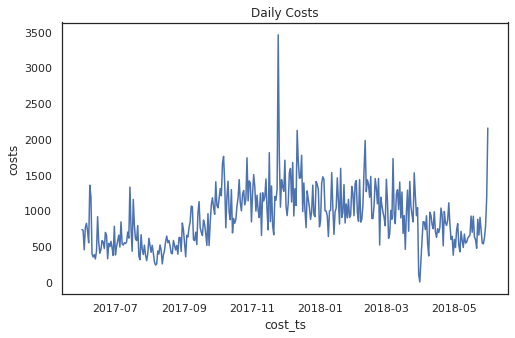

In [128]:
plt.figure(figsize = (8,5));
plt.title('Daily Costs');
plt.ylabel('Costs');
plt.xlabel('Date');
sns.lineplot(y='costs', x ='cost_ts', data= costs_per_date);

- on average we spent around 900 USD daily on marketing.
- in general the marketing costs range between 500 - 1500 USD daily
- we notice a huge spike in the costs at the end of november and it is again on `Black Friday` where the costs reached 3500 USD so probably we needed to advertise more as it is a special event 

In [129]:
costs_per_source.head()

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10


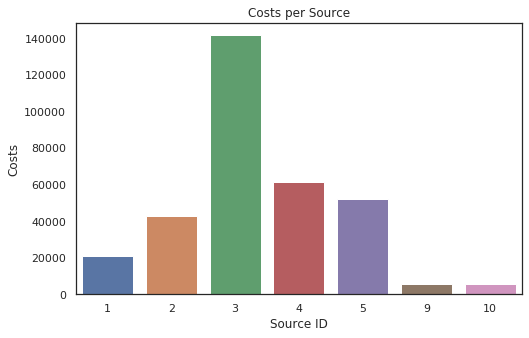

In [130]:
plt.figure(figsize = (8,5));
plt.title('Costs per Source');
sns.barplot(y='costs', x ='source_id', data= costs_per_source);
plt.ylabel('Costs');
plt.xlabel('Source ID');

when comparing the marketing costs by sources we see that we spent the most and by far on marketing for the source '3' where the overall costs almost reached 140000 USD and that is more than double the source in the second place ( Source 4 and 5 ) with 55000 to 60000 USD in Marketing Costs for each.

In [131]:
print('Overall Costs:', overall_costs)
print('Overall Revenue:', overall_Revenue)
print('Gross Profit:', overall_Revenue - overall_costs)

Overall Costs: 329131.62
Overall Revenue: 252057.19999999998
Gross Profit: -77074.42000000001


if we compare the overall costs and the overall revenue we see that we are deep in the red as we have generated around 77000 USD in losses.

#### How much did customer acquisition from each of the sources cost?

<br>

first lets find the actual source from which each user came from, we will use the following creiteria:
1. only source
2. most frequent
3. first source

In [132]:
visits.head()

,device,visit_end_ts,source_id,visit_start_ts,user_id,visit_date,session_duration_sec,session_duration_min
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,1080,18.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,1680,28.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,0,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,1440,24.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,0,0.0


In [133]:
visits['user_id'].nunique()

228169

In [134]:
# the users who have only 1 source
source_1 = visits.groupby('user_id')['source_id'].nunique().reset_index().query('source_id==1')
source_1.head()

,user_id,source_id
0,11863502262781,1
1,49537067089222,1
2,297729379853735,1
3,313578113262317,1
4,325320750514679,1


In [135]:
source_1['user_id'].nunique()

190449

In [136]:
#users who have multiple sources
user_multi_source = list(visits.groupby('user_id')['source_id'].nunique().reset_index().query(
    'source_id>1')['user_id'])
len(user_multi_source)

37720

In [137]:
# count of each source
multi_source = visits[visits['user_id'].isin(user_multi_source)].groupby(
    ['user_id', 'source_id'])['visit_start_ts'].count().reset_index().rename(
    columns = {'visit_start_ts': 'count'})
multi_source.head()

,user_id,source_id,count
0,1260655184775459,1,1
1,1260655184775459,3,3
2,2471247936243530,2,1
3,2471247936243530,9,2
4,2892676062023446,3,1


In [138]:
# most frequent sources
multi_source_grouped = multi_source[multi_source.groupby('user_id')['count'].transform(
    max) == multi_source['count']]
multi_source_grouped.head()

,user_id,source_id,count
1,1260655184775459,3,3
3,2471247936243530,9,2
4,2892676062023446,3,1
5,2892676062023446,4,1
6,2892676062023446,5,1


In [139]:
multi_source_grouped['user_id'].nunique()

37720

In [140]:
# users who have most frequent source
most_source = list(multi_source_grouped.groupby('user_id')['source_id'].nunique().reset_index().
                  query('source_id == 1')['user_id'])
most_source

[1260655184775459,
 2471247936243530,
 3605148382144603,
 5081614443770358,
 13718901769975424,
 13866352514219281,
 14982066319173628,
 15930622431697628,
 16083859506449328,
 18870633378707535,
 19133919191467791,
 19957987805132691,
 21157176339625281,
 28544559285713984,
 29340056013621514,
 30326499354452833,
 30519849625554270,
 31829771676291080,
 32932008676191273,
 33623490425653914,
 35876842118859509,
 37544711369940536,
 37922992901757687,
 38113786313418760,
 39186288429879207,
 40153291963898282,
 41987055044463519,
 43018440896201616,
 43862811563969857,
 43931187216765410,
 47365425373174780,
 48246349089291017,
 48764546538709079,
 49890001208989707,
 52319216920766916,
 57760790039845567,
 57885047520933118,
 59678141091785773,
 60530215646599706,
 61079560822490766,
 63862661827066303,
 64242443437684605,
 64244685107239813,
 65025583977947138,
 66632391782054074,
 66955290894646438,
 67645486470800121,
 69559424844179622,
 70054006483109352,
 70828222507525551,
 735

In [141]:
# actual most frequent source 
source_2 = multi_source_grouped[multi_source_grouped['user_id'].isin(most_source)][['user_id', 'source_id']]
source_2.head()

,user_id,source_id
1,1260655184775459,3
3,2471247936243530,9
7,3605148382144603,2
14,5081614443770358,3
30,13718901769975424,3


In [142]:
#still have users with multi sources so we'll take the first source
first_source = list(multi_source_grouped.groupby('user_id')['source_id'].nunique().reset_index().
                  query('source_id > 1')['user_id'].unique())

In [143]:
source_first_grouped = visits[visits['user_id'].isin(first_source)].groupby(
    ['user_id', 'source_id'])['visit_start_ts'].min().reset_index()
source_first_grouped.head()

,user_id,source_id,visit_start_ts
0,2892676062023446,3,2017-11-10 20:35:00
1,2892676062023446,4,2017-11-10 21:12:00
2,2892676062023446,5,2017-09-28 17:33:00
3,4735760515861892,2,2018-02-09 17:11:00
4,4735760515861892,9,2017-10-03 15:16:00


In [144]:
# data for first source used
source_3 = source_first_grouped[source_first_grouped.groupby('user_id')['visit_start_ts'].transform(
    min) == source_first_grouped['visit_start_ts']][['user_id', 'source_id']]
source_3.head()

,user_id,source_id
2,2892676062023446,5
4,4735760515861892,9
6,4945624519202800,5
7,6167344685364409,3
10,9616226202596325,4


In [145]:
# actual sources
clean_sources = source_1.append([source_2 , source_3])
clean_sources.head()

,user_id,source_id
0,11863502262781,1
1,49537067089222,1
2,297729379853735,1
3,313578113262317,1
4,325320750514679,1


In [146]:
clean_sources['user_id'].count()

228169

In [147]:
visits['user_id'].nunique() == clean_sources['user_id'].count()

True

In [148]:
visits = visits.merge(clean_sources, on='user_id' , how = 'left')
visits.rename(columns = {
    'source_id_x' : 'source_id',
    'source_id_y' : 'actual_source_id'
}, inplace = True)
visits.head()

,device,visit_end_ts,source_id,visit_start_ts,user_id,visit_date,session_duration_sec,session_duration_min,actual_source_id
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,1080,18.0,1
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,1680,28.0,1
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,0,0.0,1
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,1440,24.0,4
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,0,0.0,1


In [149]:
# adding the source to the conversion and purchase data
first_purchase = first_purchase.merge(clean_sources, on='user_id' , how = 'left')
first_purchase.head()

,order_ts,revenue,user_id,first_purchase_ts,order_date,first_activity_ts,cohort,days_before_purchase,days_before_conversion,liftime,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01 00:09:00,2017-06,0,0,0.0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01 00:14:00,2017-06,0,0,0.0,1
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01 00:25:00,2017-06,0,0,0.0,1
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01 00:14:00,2017-06,0,0,0.0,1
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01 07:31:00,2017-06,0,0,0.0,1


In [150]:
visits.head()

,device,visit_end_ts,source_id,visit_start_ts,user_id,visit_date,session_duration_sec,session_duration_min,actual_source_id
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,1080,18.0,1
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,1680,28.0,1
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,0,0.0,1
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,1440,24.0,4
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,0,0.0,1


Now lets start calculating the CAC by source for every visiter/user and for every buyer

In [151]:
users_per_source = visits.groupby(['actual_source_id'])['user_id'].nunique().reset_index().rename(
    columns={'actual_source_id': 'source_id',
        'user_id': 'n_users'})
users_per_source

,source_id,n_users
0,1,193604
1,2,4823
2,3,10584
3,4,10478
4,5,6045
5,6,1
6,7,3
7,9,1677
8,10,954


In [152]:
buyer_per_source = first_purchase.groupby(['source_id'])['user_id'].nunique().reset_index().rename(
    columns={'user_id': 'n_buyers'})
buyer_per_source

,source_id,n_buyers
0,1,23881
1,2,1985
2,3,3459
3,4,3816
4,5,2255
5,9,735
6,10,392


In [153]:
costs_per_source = costs_per_source.merge(users_per_source, on='source_id', how= 'left')
costs_per_source = costs_per_source.merge(buyer_per_source, on='source_id', how= 'left')

In [154]:
costs_per_source['CAC_User'] = costs_per_source['costs'] / costs_per_source['n_users']
costs_per_source['CAC_Buyer'] = costs_per_source['costs'] / costs_per_source['n_buyers']
costs_per_source

,source_id,costs,n_users,n_buyers,CAC_User,CAC_Buyer
0,1,20833.27,193604,23881,0.107608,0.872378
1,2,42806.04,4823,1985,8.875397,21.564756
2,3,141321.63,10584,3459,13.352384,40.856210
3,4,61073.60,10478,3816,5.828746,16.004612
4,5,51757.10,6045,2255,8.561969,22.952151
5,9,5517.49,1677,735,3.290095,7.506789
6,10,5822.49,954,392,6.103239,14.853291


In [155]:
revenue_per_user_source = first_purchase.groupby(['source_id', 'user_id'])['revenue'].sum().reset_index()
revenue_per_user_source.head()

,source_id,user_id,revenue
0,1,313578113262317,0.55
1,1,1575281904278712,3.05
2,1,2429014661409475,73.33
3,1,2464366381792757,2.44
4,1,2551852515556206,10.99


In [156]:
average_revenue_user_source = revenue_per_user_source.groupby('source_id')['revenue'].mean().reset_index()
average_revenue_user_source = average_revenue_user_source.rename(columns={'revenue': 'AVG_Revenue'})
average_revenue_user_source

,source_id,AVG_Revenue
0,1,5.400802
1,2,27.892947
2,3,5.788075
3,4,6.245794
4,5,8.028581
5,9,5.418408
6,10,4.518546


In [157]:
total_revenue_per_source = revenue_per_user_source.groupby('source_id')['revenue'].sum().reset_index()
total_revenue_per_source = total_revenue_per_source.rename(columns={'revenue': 'tot_Revenue'})
total_revenue_per_source

,source_id,tot_Revenue
0,1,128976.55
1,2,55367.50
2,3,20020.95
3,4,23833.95
4,5,18104.45
5,9,3982.53
6,10,1771.27


In [158]:
costs_per_source = costs_per_source.merge(average_revenue_user_source, on='source_id', how= 'left')
costs_per_source = costs_per_source.merge(total_revenue_per_source, on='source_id', how= 'left')
costs_per_source['Revenue_User'] = costs_per_source['tot_Revenue'] / costs_per_source['n_users']
costs_per_source

,source_id,costs,n_users,n_buyers,CAC_User,CAC_Buyer,AVG_Revenue,tot_Revenue,Revenue_User
0,1,20833.27,193604,23881,0.107608,0.872378,5.400802,128976.55,0.666187
1,2,42806.04,4823,1985,8.875397,21.564756,27.892947,55367.50,11.479888
2,3,141321.63,10584,3459,13.352384,40.856210,5.788075,20020.95,1.891624
3,4,61073.60,10478,3816,5.828746,16.004612,6.245794,23833.95,2.274666
4,5,51757.10,6045,2255,8.561969,22.952151,8.028581,18104.45,2.994946
5,9,5517.49,1677,735,3.290095,7.506789,5.418408,3982.53,2.374794
6,10,5822.49,954,392,6.103239,14.853291,4.518546,1771.27,1.856677


from the table above we can see the CAC for every visiter and CAC for every buyer and we can compare them to the average revenue for every buyer by source and from that we notice:
1. with the exception for the sources 1 and 2 we are paying to attract a buyer alot more than the revenue we will get from that buyer.
2. our buyers come mostly from the source 1
3. we have very little buyers from the sources 9 and 10 

In [159]:
costs.head()

,source_id,cost_ts,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [160]:
costs['cost_month'] = costs['cost_ts'].astype('datetime64[M]')
costs.head()

,source_id,cost_ts,costs,cost_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [161]:
monthly_costs = costs.groupby('cost_month')['costs'].sum()
monthly_costs.head()

cost_month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
Name: costs, dtype: float64

In [162]:
report.head()

,first_order_month,n_buyers,order_month,revenue,gross_profit,lifetime,ltv
0,2017-06-01,2023,2017-06-01,9557.49,4778.745,0,2.362207
1,2017-06-01,2023,2017-07-01,981.82,490.910,1,0.242664
2,2017-06-01,2023,2017-08-01,885.34,442.670,2,0.218819
3,2017-06-01,2023,2017-09-01,1931.30,965.650,3,0.477336
4,2017-06-01,2023,2017-10-01,2068.58,1034.290,4,0.511265


In [163]:
report_cac = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='cost_month')
report_cac['cac'] = report_cac['costs'] / report_cac['n_buyers']
report_cac.head()

,first_order_month,n_buyers,order_month,revenue,gross_profit,lifetime,ltv,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,4778.745,0,2.362207,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,490.910,1,0.242664,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,885.34,442.670,2,0.218819,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,965.650,3,0.477336,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,1034.290,4,0.511265,18015.0,8.905091


In [164]:
monthly_cac = report_cac.groupby('first_order_month')['cac'].mean().reset_index()
monthly_cac['first_order_month'] = monthly_cac['first_order_month'].apply(lambda x: x.strftime('%Y-%m'))
monthly_cac

,first_order_month,cac
0,2017-06,8.905091
1,2017-07,9.485486
2,2017-08,10.796015
3,2017-09,9.441654
4,2017-10,8.369327
5,2017-11,9.288870
6,2017-12,8.741809
7,2018-01,9.937302
8,2018-02,8.962758
9,2018-03,8.608907


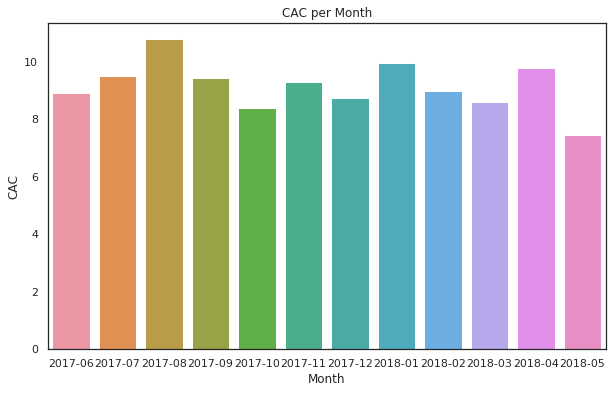

In [165]:
plt.figure(figsize = (10,6));
plt.title('CAC per Month');
sns.barplot(y='cac', x ='first_order_month', data= monthly_cac);
plt.ylabel('CAC');
plt.xlabel('Month');

In [166]:
monthly_cac['cac'].describe()

count    12.000000
mean      9.147357
std       0.855737
min       7.437841
25%       8.708584
50%       9.125814
75%       9.562421
max      10.796015
Name: cac, dtype: float64

In [167]:
print('Average monthly CAC:', "{:.2f}".format(monthly_cac['cac'].mean()))

Average monthly CAC: 9.15


In [168]:
n_buyers_year = orders['user_id'].nunique()
costs_year = costs['costs'].sum()
print('CAC per Year:', "{:.2f}".format(costs_year/ n_buyers_year))

CAC per Year: 9.01


- from the graph above we see that the monthly cac ranges between 7.5 - 10.5 USD
- CAC was the highest in August 2017 and the lowest in May 2018
- on Monthly Average, accuiring a customer costs 9.15 USD 
- if we calculate the CAC for the entire year we see that we had a CAC of: 9 USD 

#### How worthwhile where the investments? (ROI)

In [169]:
ROI = costs_per_source[['source_id', 'costs', 'tot_Revenue']].copy()
ROI

,source_id,costs,tot_Revenue
0,1,20833.27,128976.55
1,2,42806.04,55367.50
2,3,141321.63,20020.95
3,4,61073.60,23833.95
4,5,51757.10,18104.45
5,9,5517.49,3982.53
6,10,5822.49,1771.27


In [170]:
ROI['ROI'] = costs_per_source['Revenue_User'] / costs_per_source['CAC_User']
ROI['net_revenue'] = costs_per_source['tot_Revenue'] - costs_per_source['costs']
ROI

,source_id,costs,tot_Revenue,ROI,net_revenue
0,1,20833.27,128976.55,6.190893,108143.28
1,2,42806.04,55367.50,1.293451,12561.46
2,3,141321.63,20020.95,0.141669,-121300.68
3,4,61073.60,23833.95,0.390250,-37239.65
4,5,51757.10,18104.45,0.349796,-33652.65
5,9,5517.49,3982.53,0.721801,-1534.96
6,10,5822.49,1771.27,0.304212,-4051.22


In [171]:
print('overall Net_Revenue:', "{:.2f}".format(ROI['net_revenue'].sum()))

overall Net_Revenue: -77074.42


- as we can see from the the table above the ROi for all of the Sources other than (1 and 2) are less than 1 so in other words the investments in these sources didn't pay off.
- the same fact we can see clearer when we look at the net revenue where most of the sources are in the red. 
- we can see that especially source 3 have accumulated a huge loss that reached more than 120k USD
- and in generall we can see that our overall net revenue is also negative and our business can be considered a losing business.

In [172]:
report_cac['romi'] = report_cac['ltv'] / report_cac['cac']
report_cac.head()

,first_order_month,n_buyers,order_month,revenue,gross_profit,lifetime,ltv,costs,cac,romi
0,2017-06-01,2023,2017-06-01,9557.49,4778.745,0,2.362207,18015.0,8.905091,0.265265
1,2017-06-01,2023,2017-07-01,981.82,490.910,1,0.242664,18015.0,8.905091,0.027250
2,2017-06-01,2023,2017-08-01,885.34,442.670,2,0.218819,18015.0,8.905091,0.024572
3,2017-06-01,2023,2017-09-01,1931.30,965.650,3,0.477336,18015.0,8.905091,0.053603
4,2017-06-01,2023,2017-10-01,2068.58,1034.290,4,0.511265,18015.0,8.905091,0.057413


In [173]:
romi_pivot_cohort = report_cac.pivot_table(index='first_order_month', columns='lifetime', values='romi', aggfunc='mean')

romi_pivot_cohort_cumsum = romi_pivot_cohort.cumsum(axis=1).round(2) 
romi_pivot_cohort_cumsum

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.27,0.29,0.32,0.37,0.43,0.47,0.52,0.56,0.59,0.62,0.65,0.67
2017-07-01,0.32,0.33,0.37,0.39,0.40,0.40,0.41,0.42,0.43,0.43,0.44,NaN
2017-08-01,0.24,0.27,0.29,0.31,0.33,0.34,0.35,0.37,0.38,0.39,NaN,NaN
2017-09-01,0.30,0.36,0.39,0.60,0.62,0.65,0.69,0.70,0.71,NaN,NaN,NaN
2017-10-01,0.30,0.33,0.34,0.35,0.36,0.37,0.37,0.38,NaN,NaN,NaN,NaN
2017-11-01,0.28,0.30,0.31,0.33,0.34,0.34,0.34,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.27,0.29,0.34,0.40,0.42,0.44,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.21,0.22,0.24,0.25,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.23,0.25,0.25,0.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


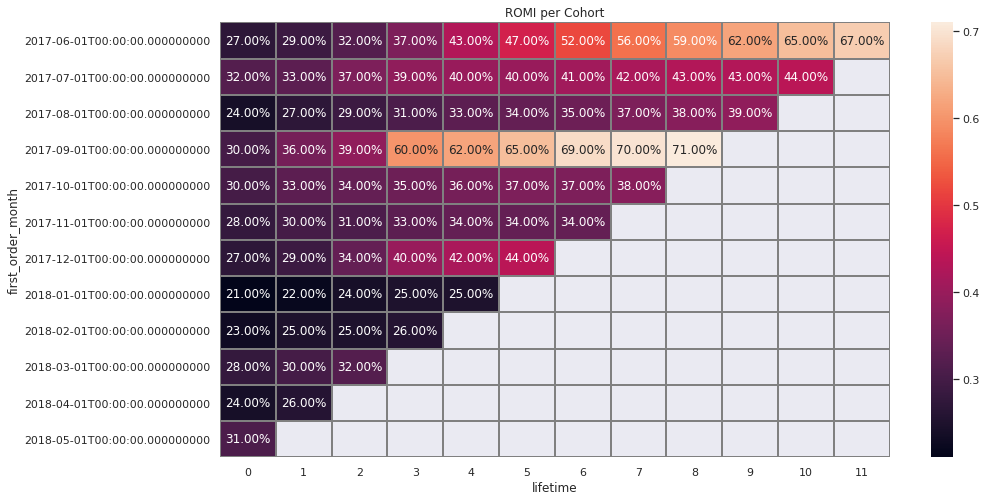

In [174]:
sns.set(style='dark')
plt.figure(figsize=(15, 8))
plt.title('ROMI per Cohort')
sns.heatmap(romi_pivot_cohort_cumsum, annot=True, fmt='.2%', linewidths=1, linecolor='gray');

In [175]:
romi_pivot_cohort.cumsum(axis=1).mean(axis=0) 

lifetime
0     0.270408
1     0.290992
2     0.315535
3     0.359870
4     0.391473
5     0.429938
6     0.448410
7     0.484976
8     0.526936
9     0.482244
10    0.547329
11    0.666991
dtype: float64

- It is clear from the heatmap above that none of our cohort has paid off yet.
- the max pay back we got was for the september 2017 cohort as we got 71% of our costs back.
- the june 2017 has paid back only 67% of the costs even though it had the longest lifetime
- other the above mentioned cohorts no cohort had paid back more than 44% of its costs.
- on average and after 1 year we got only 67% of our costs back.

## Step 3. Write a conclusion: advise marketing experts how much money to invest and where.   

<br>

- After considering our overall analysis we can come to the conclusion that our business at athe moment is a losing business and is just accumulating losses and should take a fast and decicive descesion to try and stop the money bleeding.
<br>

- our advecies are one of the following: 
1. we can shut down the whole business because it is a losing one as we said before.
2. we can try and adjust our costs t otry and salvage the situation and this can be done as follows:  

    a. cut down the investments in the marketing in all the sources other than (1 - 2 ) and in particular 'source 3'.  
    b. raise the invesments in the sources (1 - 2) and in particular 'source 1' as it is the most profitable source.